In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
from scipy import stats
import utils
import seaborn as sns
import pingouin as pg
import matplotlib.cm as cm

from natsort import index_natsorted



g_sequences = {}
g_chunks_sizes = {}
digit_change = {}
g_sequences[0] = ['13524232514', '51423252413', '35421252143', '14325242135'] #Group 1 sequences
g_sequences[1] = ['13524232514', '51423252413', '41325242351', '14325242135'] #Group 2 sequences

seq_length = len(g_sequences[0][0]) #Length of sequences

g_chunks_sizes[0] = ['2333', '3332', '2333', '3332']  #Group1 chunking structures
g_chunks_sizes[1] = ['3332', '2333', '3332', '2333']  # Group2 chunking structures

digit_change = [5, 7, 9] #position of changed digit in changed sequence

fingers = ['1', '2', '3', '4', '5'] #mapping of fingers to numbers

unbiased_finger_presses = [2, 3, 5, 6, 8, 9] #position of fingerpresses that are within chunk in one group and between for the other

iti = 3000   #Inter trial interval
execTime = 10000 # msecs for each trial maximum
planTime = 0 # msecs for planning before movement 
hand = 2 #left or right hand

total_sub_num = 6
# total_num_blocks = 10
num_train_blocks = 5
num_test_blocks = 5
total_num_blocks = num_train_blocks + num_test_blocks
num_trials_per_train_block = 20
num_seq_changed_trials_per_test_block = 8
num_seq_unchanged_trials_per_test_block = 8
num_random_trials_per_test_block = 8
num_trials_per_test_block = num_seq_changed_trials_per_test_block + num_seq_unchanged_trials_per_test_block + num_random_trials_per_test_block

# Analyzing Dat Files

In [2]:
subjs_list = utils.read_dat_files_subjs_list(range(1, total_sub_num+1))
subjs_list = [utils.remove_error_trials(subj) for subj in subjs_list] ##Removing the error trials


for subj in subjs_list: ###Adding IPIs
    utils.add_IPI(subj)


subjs = pd.concat(subjs_list) ###Merging all subjs into one dataframe

subjs_presses = utils.finger_melt(subjs).rename(columns={'isError' : 'isTrialError'})

subjs_presses_unbiased = utils.finger_melt(subjs.drop(columns = ['IPI' + str(x) for x in range(1,seq_length) if x not in unbiased_finger_presses]))


Creating a dataframe with fingerpresses in each row:

In [199]:
# subjs.to_csv(utils.path_misc+'subjs.csv', index = False)
# subjs_presses.to_csv(utils.path_misc+'subjs_presses.csv', index = False)
# subjs_presses_unbiased.to_csv(utils.path_misc+'subjs_presses_unbiased.csv', index = False)

In [200]:
# utils.remove_remaining_next_error_presses(subjs_presses)

In [201]:
# utils.remove_next_error_presses(subjs_presses)

## Pattern of RT:

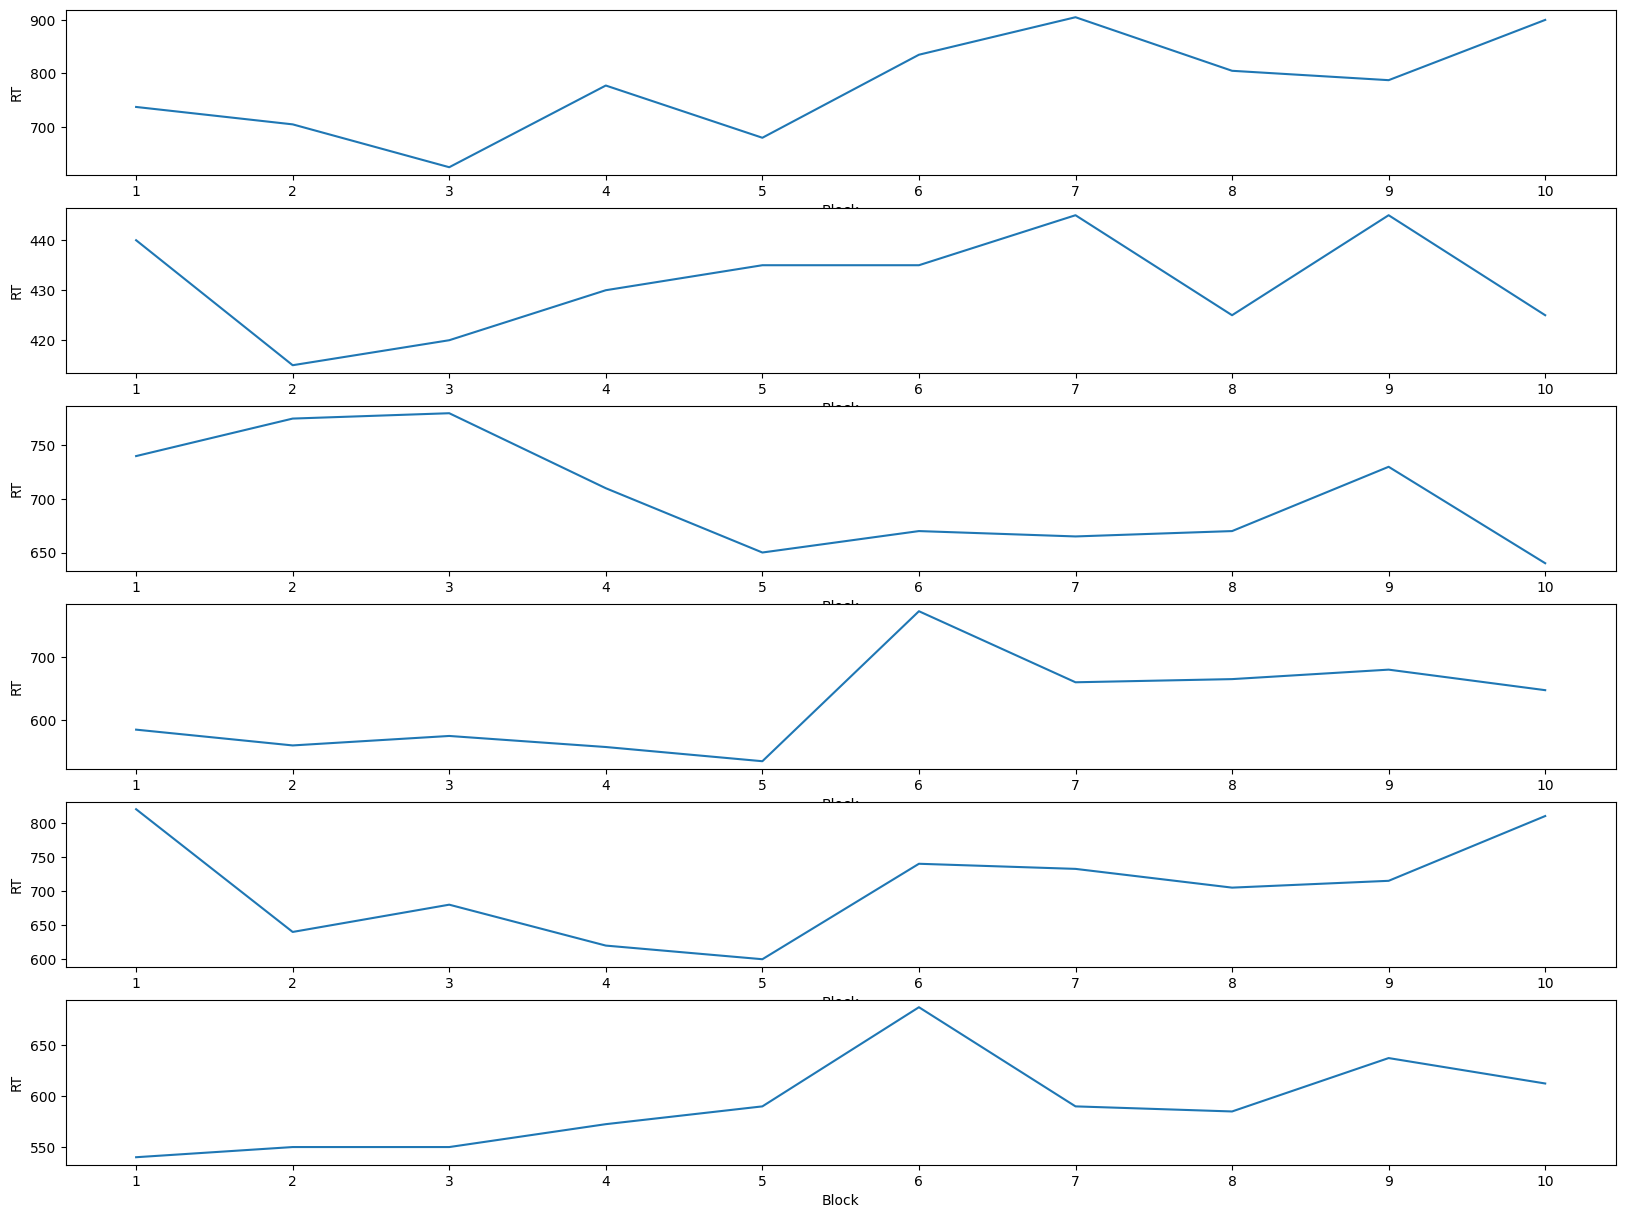

In [6]:
fig , axs = plt.subplots(total_sub_num,1, figsize=(20,15))
for i, subj in enumerate(subjs_list):
    BN_goruped = subj.groupby("BN")
    axs[i].plot(BN_goruped['RT'].agg('median'))
    axs[i].set_xticks(range(1,11))
    axs[i].set_ylabel('RT')
    axs[i].set_xlabel('Block')


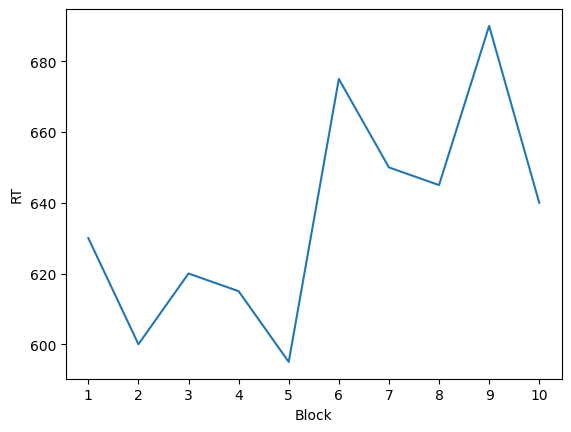

In [7]:
utils.RT_pattern(subjs)

## Pattern of IPIs:

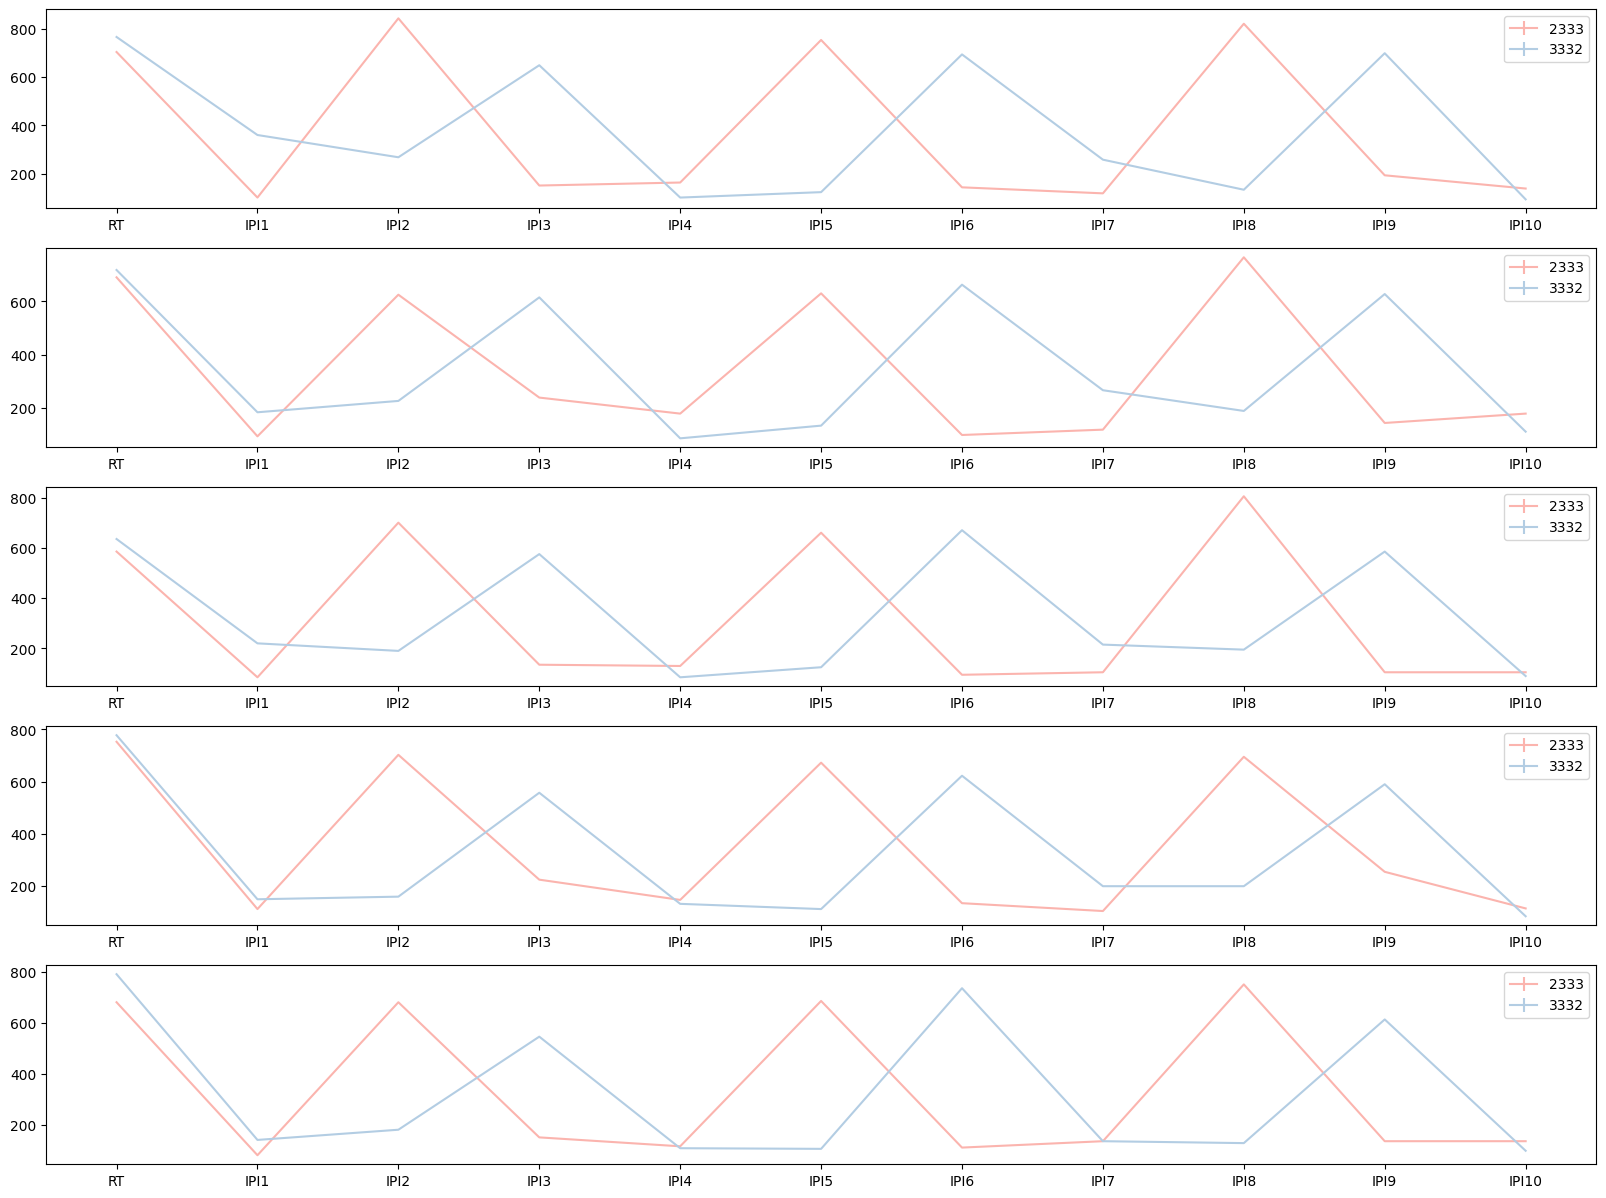

In [8]:
utils.IPI_pattern_chunk(subjs_list[0][subjs_list[0]['isTrain'] == True])

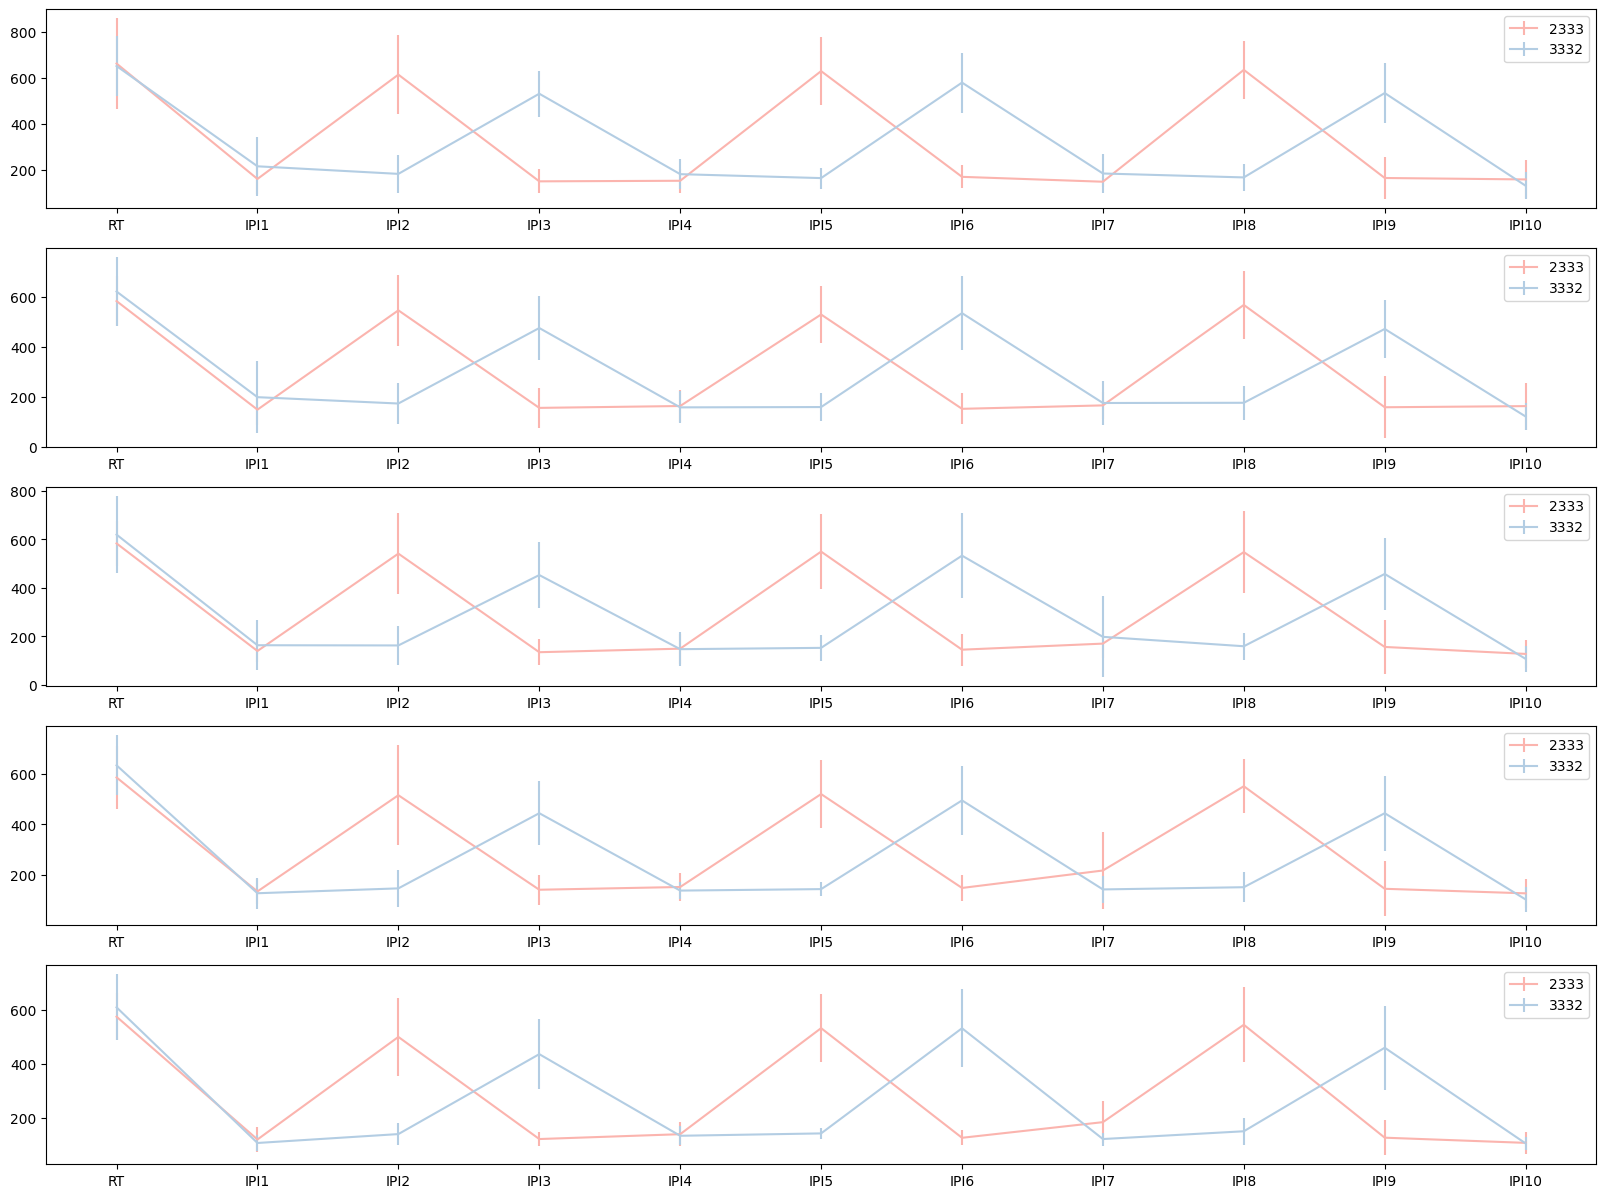

In [9]:
utils.IPI_pattern_chunk(subjs[subjs['isTrain'] == 1])

## Trend of within vs between IPIs during training:

In [10]:
subjs_presses_unbiased['is_between'] = subjs_presses_unbiased.apply(utils.flag_between_within_press, axis = 1)
subjs_presses['is_between'] = subjs_presses.apply(utils.flag_between_within_press, axis = 1)

subjs_list_train = [utils.extract_train(subj) for subj in subjs_list]
subjs_list_test = [utils.extract_test(subj) for subj in subjs_list]

subjs_train = utils.extract_train(subjs)
subjs_test = utils.extract_test(subjs)



/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj['between_IPI_sum'] = subj.apply(between_calc, axis = 1)
/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj['within_IPI_sum'] = subj.apply(within_calc, axis = 1)
/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:283: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

            Source            SS  ddof1  ddof2            MS          F  \
0       is_between  2.137594e+06      1      5  2.137594e+06  67.569997   
1               BN  2.575979e+04      4     20  6.439948e+03  13.242123   
2  is_between * BN  7.053125e+03      4     20  1.763281e+03   3.094664   

      p-unc  p-GG-corr       ng2       eps  
0  0.000434   0.000434  0.802593  1.000000  
1  0.000020   0.004146  0.046706  0.389978  
2  0.038998   0.113380  0.013237  0.366657  


/Users/amin/Library/Python/3.9/lib/python/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/amin/Library/Python/3.9/lib/python/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  data.groupby(level=1, axis=1, observed=True, group_keys=False)


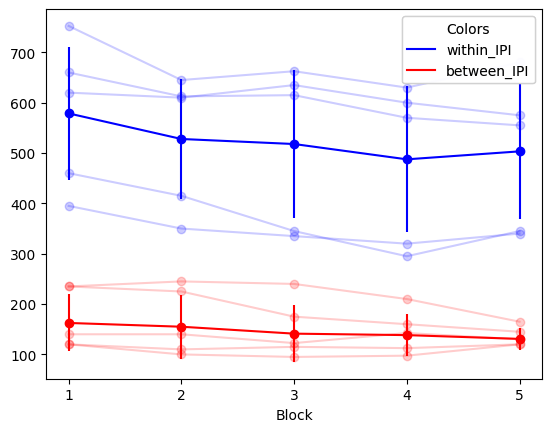

In [11]:
utils.within_between_trend_train(subjs_presses)

            Source            SS  ddof1  ddof2            MS          F  \
0       is_between  2.092534e+06      1      5  2.092534e+06  70.065837   
1               BN  2.500271e+04      4     20  6.250677e+03  12.734015   
2  is_between * BN  7.723542e+03      4     20  1.930885e+03   3.100838   

      p-unc  p-GG-corr       ng2       eps  
0  0.000398   0.000398  0.798615  1.000000  
1  0.000026   0.003328  0.045240  0.427944  
2  0.038739   0.105758  0.014426  0.404671  


/Users/amin/Library/Python/3.9/lib/python/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/amin/Library/Python/3.9/lib/python/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  data.groupby(level=1, axis=1, observed=True, group_keys=False)


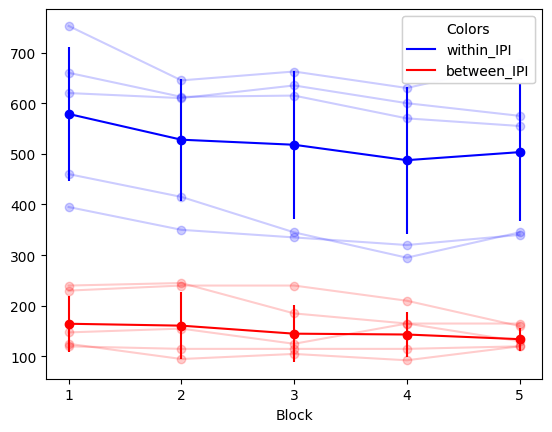

In [12]:
utils.within_between_trend_train(subjs_presses_unbiased)

/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_test['isChanged'] = subj_test.apply(is_digit_changed, axis = 1)
/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_test['isRand'] = subj_test.apply(is_rand, axis = 1)


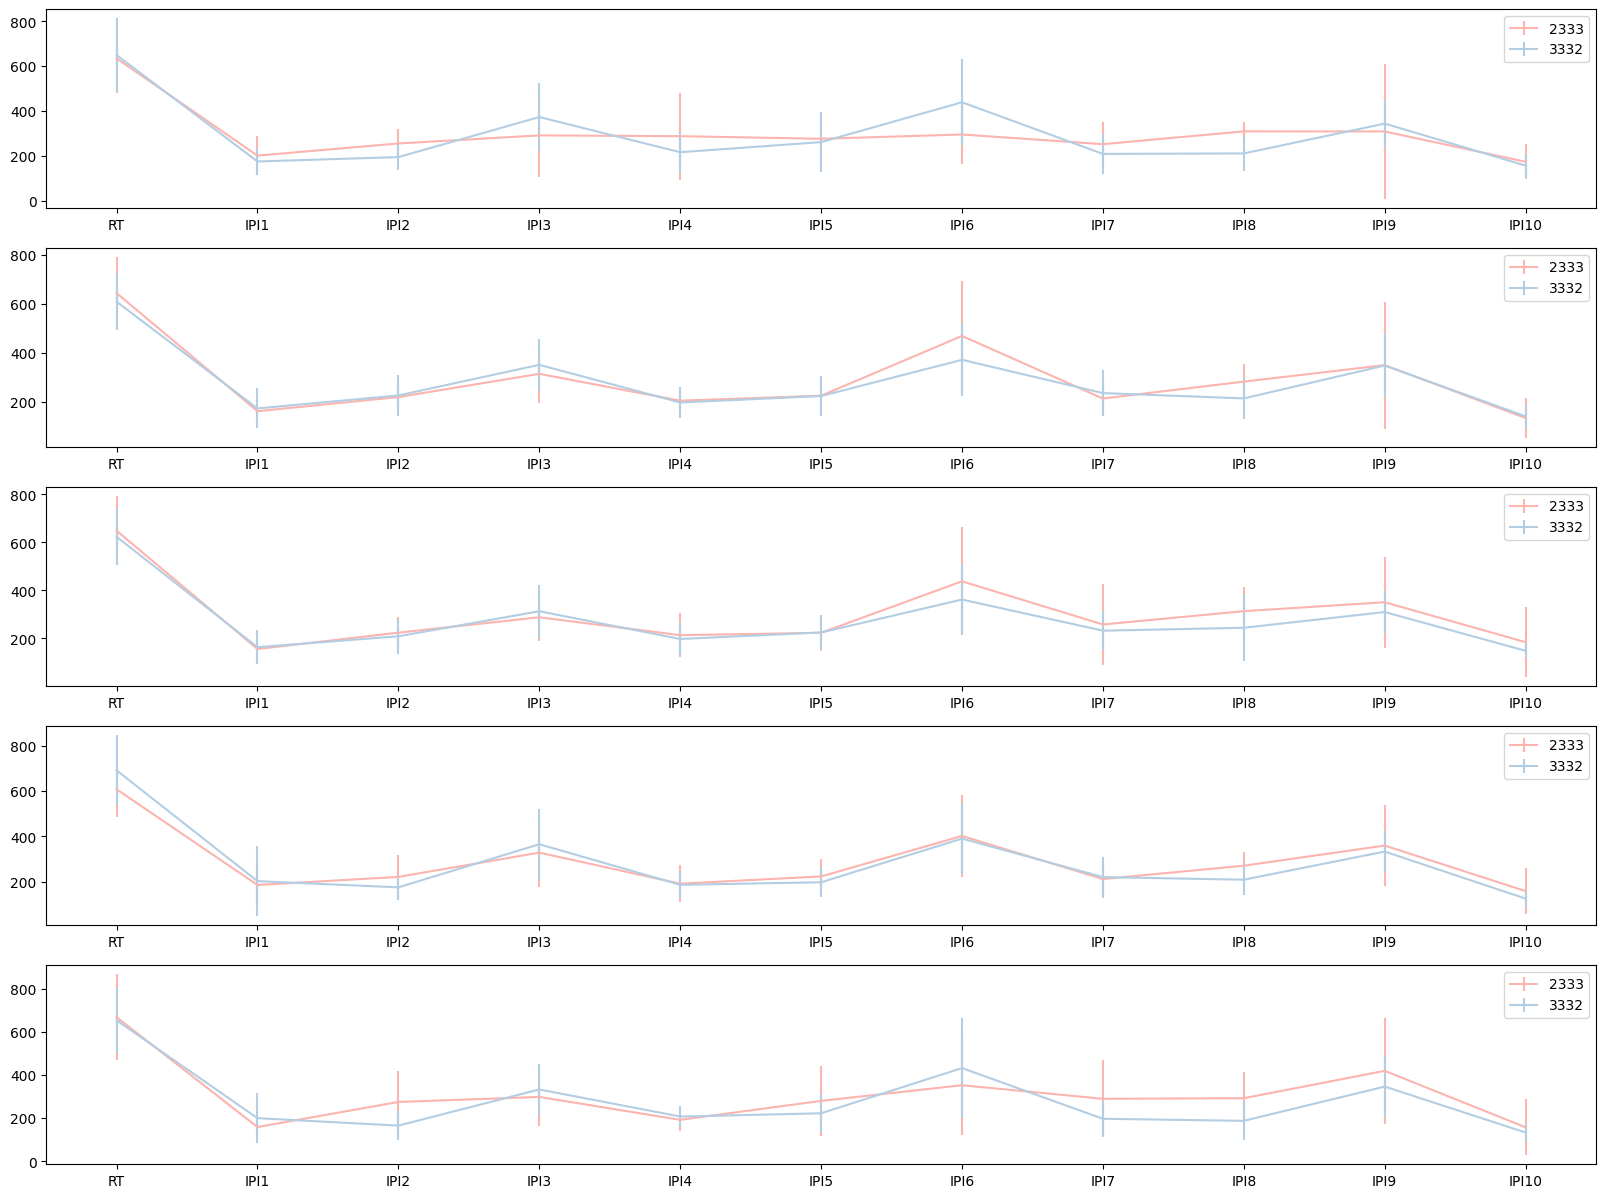

In [13]:
subjs_test_changed, subjs_test_unchanged, subjs_test_rand =  utils.get_test_changed_unchanged_rand(subjs_test)

utils.IPI_pattern_chunk(subjs_test_unchanged)

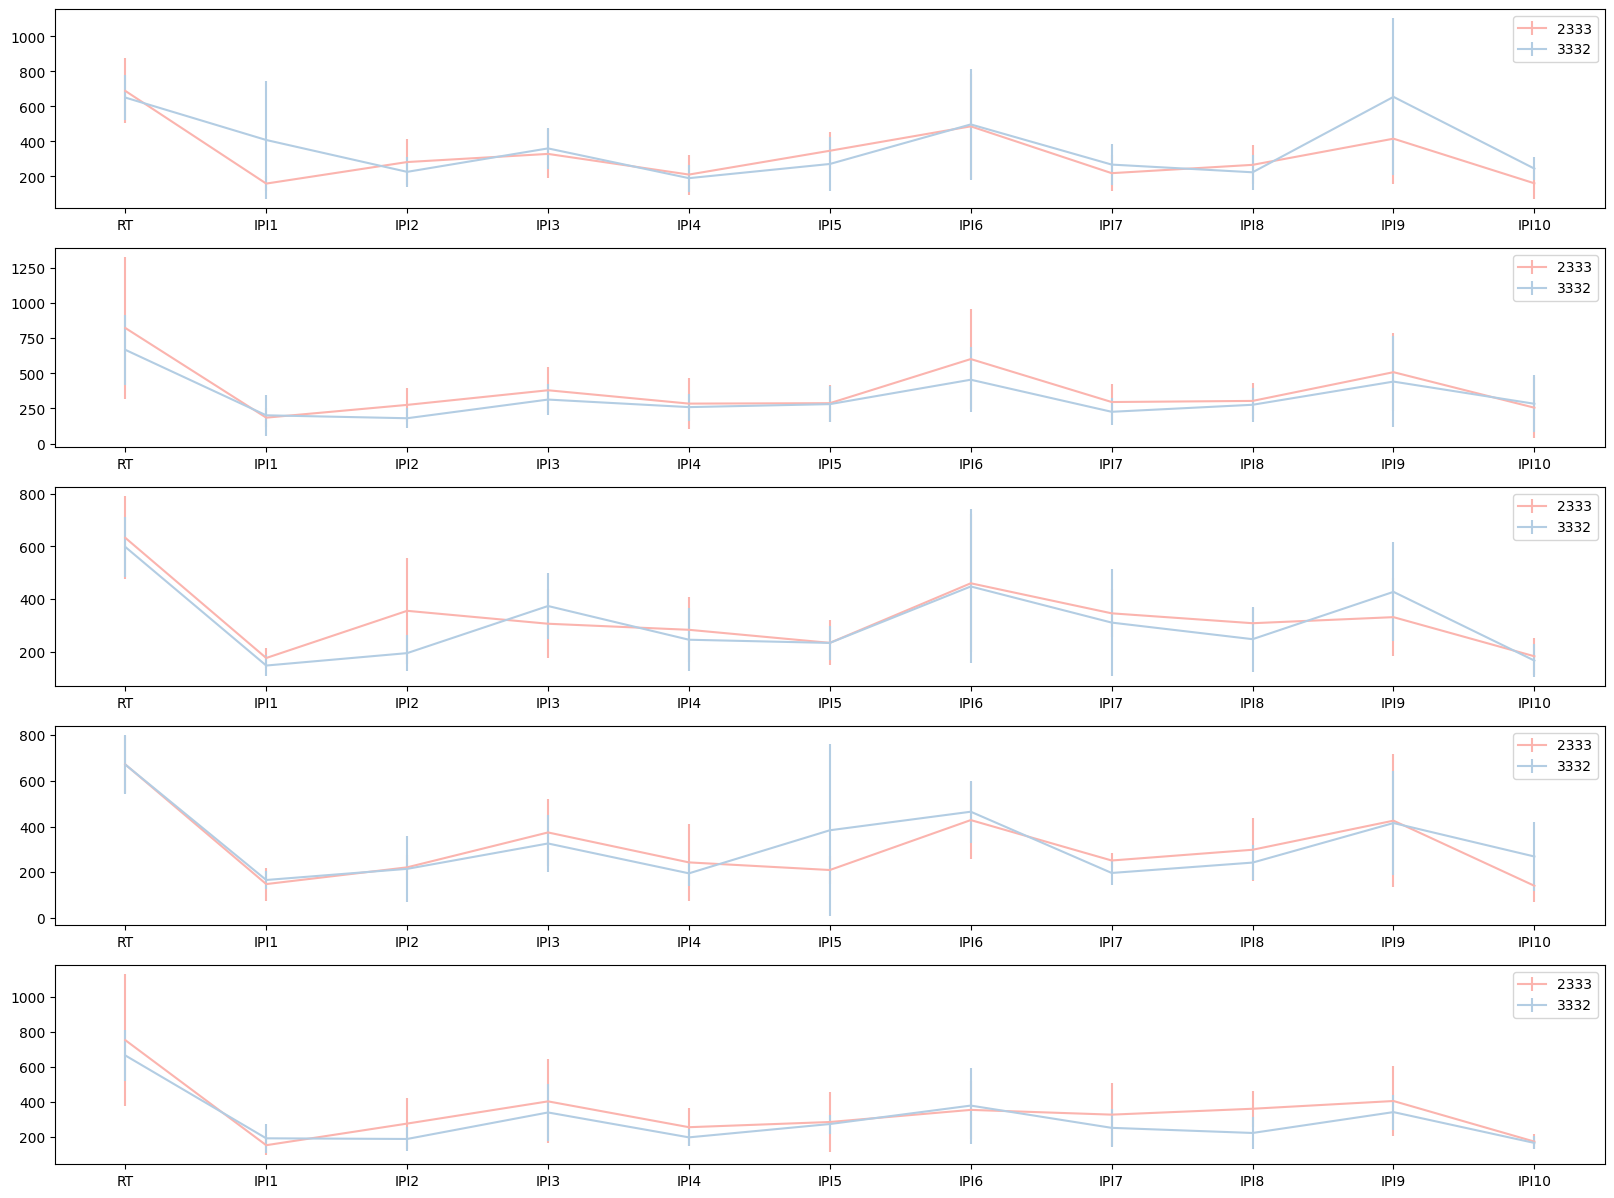

In [14]:
utils.IPI_pattern_chunk(subjs_test_changed)

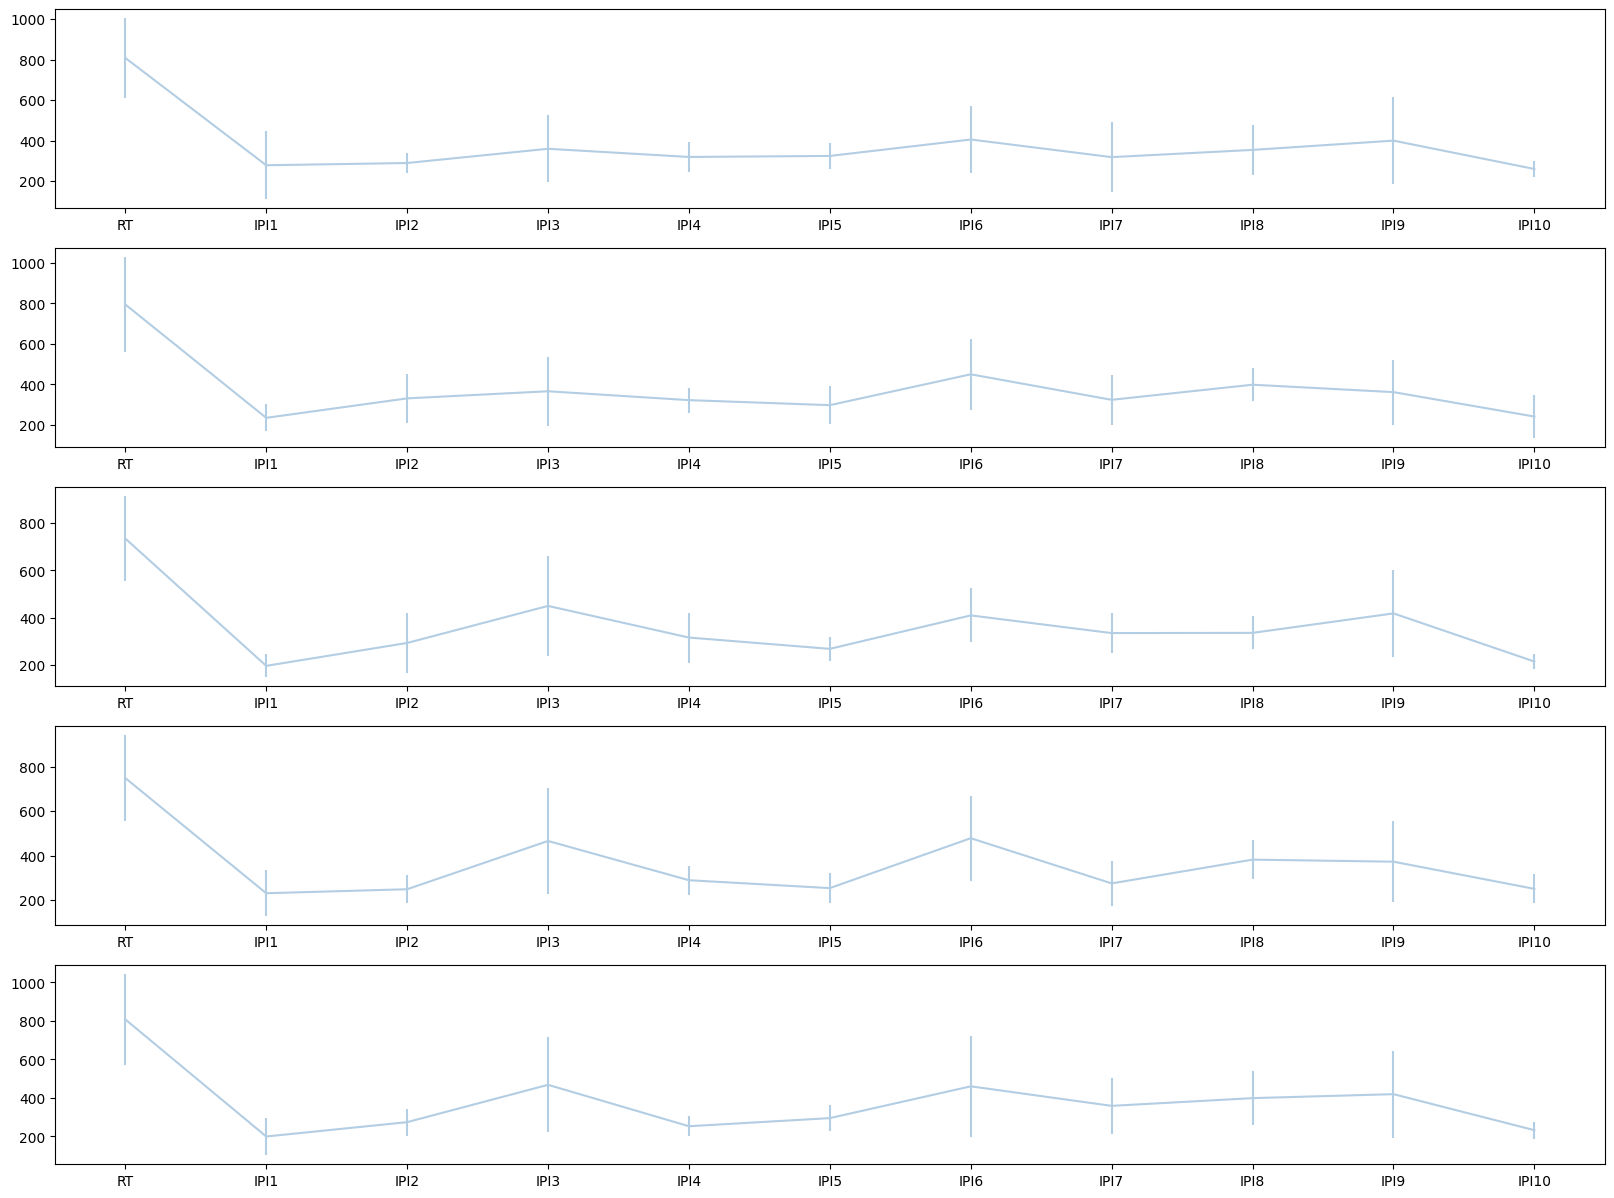

In [15]:
cmap = cm.Pastel1
fig, axs = plt.subplots(num_train_blocks,1, figsize = (20,15))

for idx, (block , block_data) in enumerate(subjs_test_rand.drop(columns='seq').groupby(['BN'])):
    chunk_data_mean = block_data.groupby(['SubNum'])[['RT'] + ['IPI' + str(_) for _ in range(1, seq_length)]].mean()
    axs[idx].errorbar(chunk_data_mean.columns, chunk_data_mean.mean(), chunk_data_mean.std(), color = cmap(1))


plt.show()

/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_test['isChanged'] = subj_test.apply(is_digit_changed, axis = 1)
/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_test['isRand'] = subj_test.apply(is_rand, axis = 1)


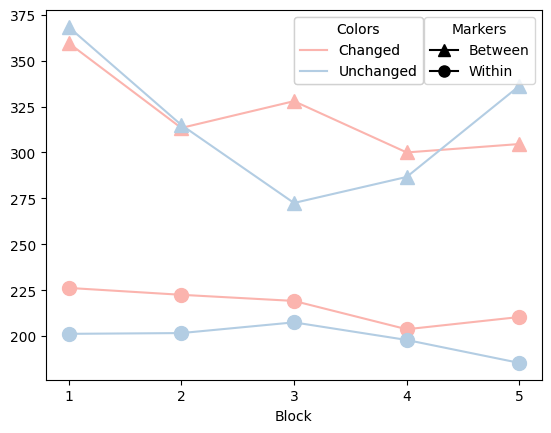

In [16]:
utils.within_between_trend_press_test(subjs_presses)

/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_test['isChanged'] = subj_test.apply(is_digit_changed, axis = 1)
/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_test['isRand'] = subj_test.apply(is_rand, axis = 1)


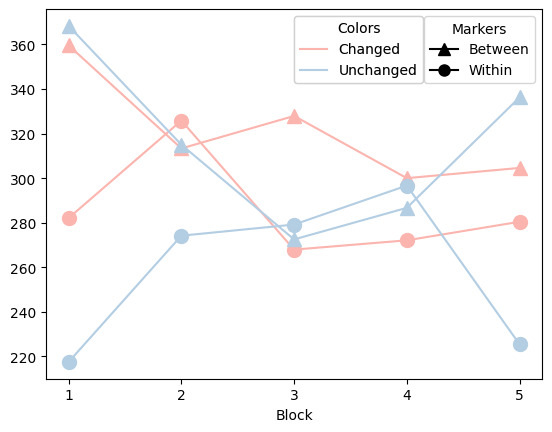

In [17]:
utils.within_between_trend_press_test(subjs_presses_unbiased)

/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_test['isChanged'] = subj_test.apply(is_digit_changed, axis = 1)
/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_test['isRand'] = subj_test.apply(is_rand, axis = 1)


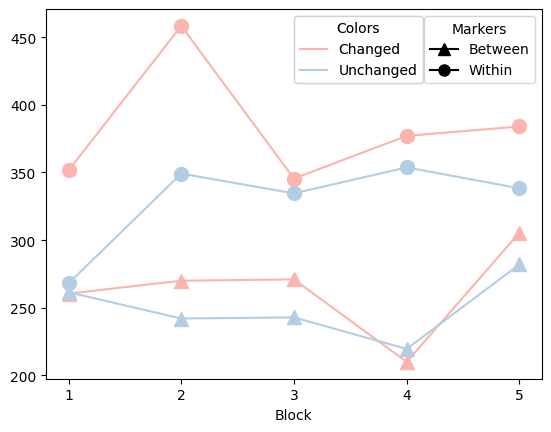

In [18]:

utils.within_between_trend_press_test(subjs_presses_unbiased[subjs_presses_unbiased['ChunkSize'] == '2333'])


/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_test['isChanged'] = subj_test.apply(is_digit_changed, axis = 1)
/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_test['isRand'] = subj_test.apply(is_rand, axis = 1)


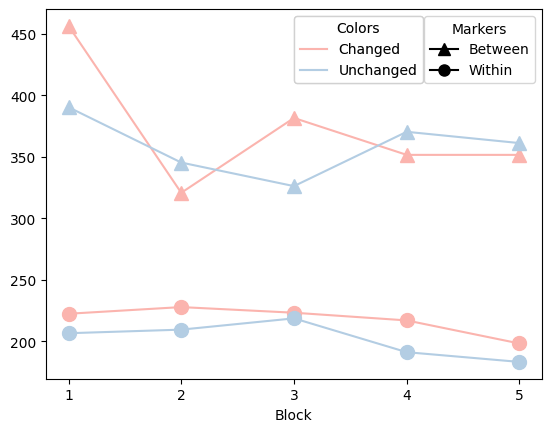

In [19]:
utils.within_between_trend_press_test(subjs_presses_unbiased[subjs_presses_unbiased['ChunkSize'] == '3332'])

/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_test['isChanged'] = subj_test.apply(is_digit_changed, axis = 1)
/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_test['isRand'] = subj_test.apply(is_rand, axis = 1)


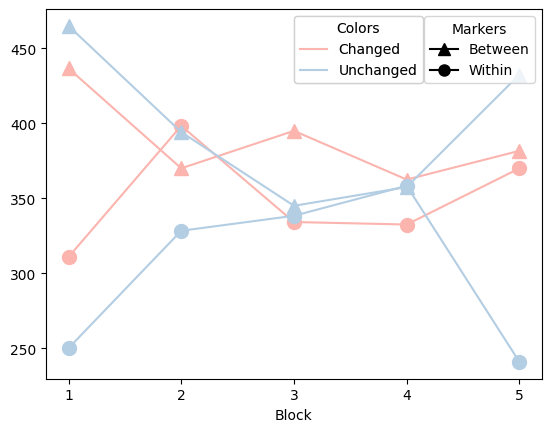

In [20]:
utils.within_between_trend_press_test(subjs_presses_unbiased[subjs_presses_unbiased['group'] == 0])

/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_test['isChanged'] = subj_test.apply(is_digit_changed, axis = 1)
/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_test['isRand'] = subj_test.apply(is_rand, axis = 1)


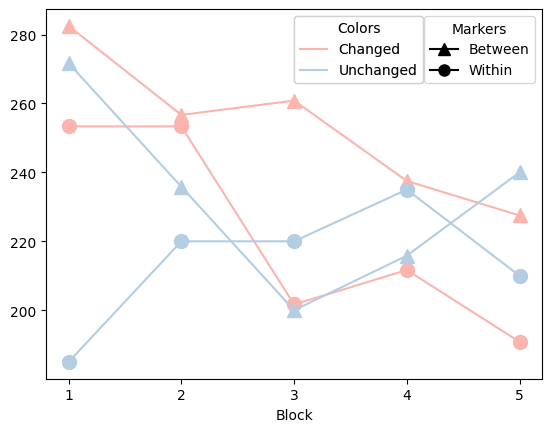

In [21]:
utils.within_between_trend_press_test(subjs_presses_unbiased[subjs_presses_unbiased['group'] == 1])

## Inspecting the change effect:

In [3]:
subjs_list = utils.read_dat_files_subjs_list(range(1, total_sub_num+1))
subjs_list = [utils.remove_error_trials(subj) for subj in subjs_list] ##Removing the error trials


for subj in subjs_list: ###Adding IPIs
    utils.add_IPI(subj)


subjs = pd.concat(subjs_list) ###Merging all subjs into one dataframe

subjs_list_train = [utils.extract_train(subj) for subj in subjs_list]
subjs_list_test = [utils.extract_test(subj) for subj in subjs_list]

subjs_train = utils.extract_train(subjs)
subjs_test = utils.extract_test(subjs)

subjs_presses = utils.finger_melt(subjs).rename(columns={'isError' : 'isTrialError'})

subjs_presses_unbiased = utils.finger_melt(subjs.drop(columns = ['IPI' + str(x) for x in range(1,seq_length) if x not in unbiased_finger_presses]))

# subjs_presses = utils.remove_error_presses(subjs_presses)

# subjs_presses = utils.remove_remaining_next_error_presses(subjs_presses)

# subjs_presses = utils.remove_next_error_presses(subjs_presses)

/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj['between_IPI_sum'] = subj.apply(between_calc, axis = 1)
/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj['within_IPI_sum'] = subj.apply(within_calc, axis = 1)
/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:283: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [4]:
subjs_presses

,BN,TN,SubNum,group,hand,isTrain,seq,ChunkSize,digitChangePos,digitChangeValue,isTrialError,timingError,IPI_Number,IPI_Value,N,Press_Number,Press_Value,Response_Number,Response_Value,isPressError
0,1,1,1,0,2,1,13524232514,2333,9,2,0,0,IPI1,85.0,2,press2,3,response2,3,False
1,1,3,1,0,2,1,51423252413,3332,5,2,0,0,IPI1,345.0,2,press2,1,response2,1,False
2,1,4,1,0,2,1,13524232514,2333,5,5,0,0,IPI1,35.0,2,press2,3,response2,3,False
3,1,5,1,0,2,1,35421252143,2333,9,4,0,0,IPI1,225.0,2,press2,5,response2,5,False
4,1,7,1,0,2,1,35421252143,2333,9,4,0,0,IPI1,120.0,2,press2,5,response2,5,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10125,10,20,6,1,2,0,23143211545,2333,7,2,0,0,IPI10,315.0,11,press11,5,response11,5,False
10126,10,21,6,1,2,0,13214143135,3332,7,3,0,0,IPI10,145.0,11,press11,5,response11,5,False
10127,10,22,6,1,2,0,41325242351,3332,9,5,0,0,IPI10,155.0,11,press11,1,response11,1,False
10128,10,23,6,1,2,0,13524232514,3332,7,1,0,0,IPI10,135.0,11,press11,4,response11,4,False


In [204]:
press_diff = utils.calculate_changed_unchanged_press_diff(subjs_presses[subjs_presses['isTrain'] == 0])

press_diff_unbiased = utils.calculate_changed_unchanged_press_diff(subjs_presses_unbiased[subjs_presses_unbiased['isTrain'] == 0])

/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_test['isChanged'] = subj_test.apply(is_digit_changed, axis = 1)
/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_test['isRand'] = subj_test.apply(is_rand, axis = 1)
/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [36]:
# press_diff.to_csv(utils.path_misc+'presses_test_diff.csv', index = False)
# press_diff_unbiased.to_csv(utils.path_misc+'presses_test_diff_unbiased.csv', index = False)

In [16]:
def flag_between_within_press_test(row: pd.Series):
        """
        Calculates whether the fingpress is a within chunk IPI 
        """

        chunksList = [int(char) for char in '3332']
        cumulative_chunks_lists = ['IPI' + str(sum(chunksList[:i+1])) for i in range(len(chunksList))]
        return (row['IPI_Number'] in cumulative_chunks_lists)

In [206]:
press_diff['is_between'] = press_diff.apply(flag_between_within_press_test, axis = 1)

## Error Analysis:

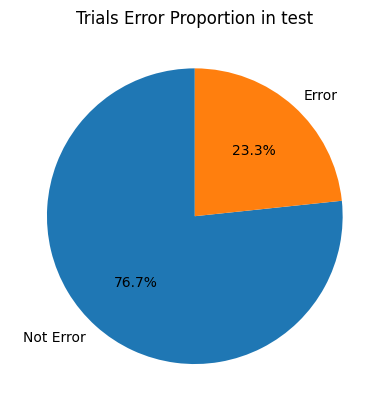

In [37]:
plt.pie(subjs_test['isError'].value_counts(), labels=['Not Error','Error'], autopct='%1.1f%%',startangle=90)
plt.title('Trials Error Proportion in test')
plt.show()

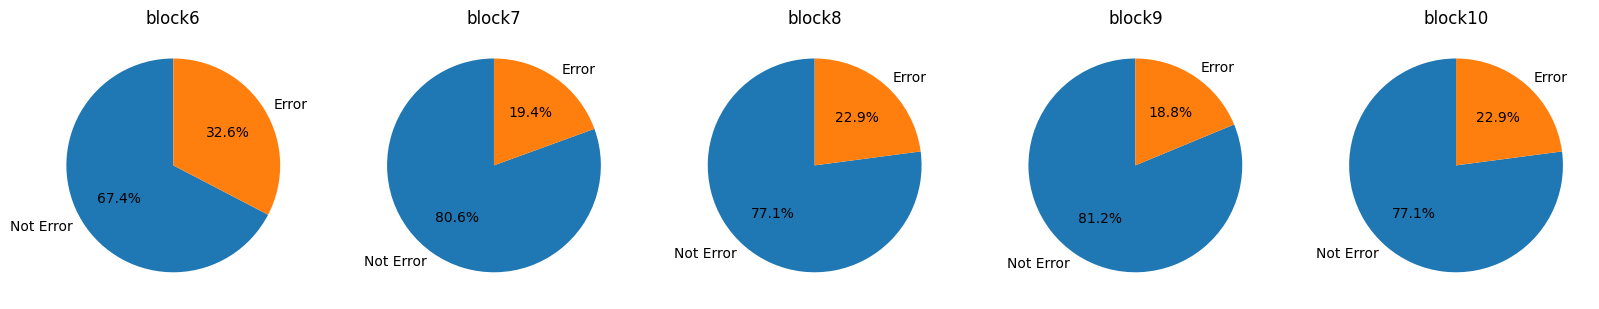

In [38]:
fig, axs = plt.subplots(1,num_test_blocks, figsize= (20,15))
for idx, (blocknum, block) in enumerate(subjs_test.groupby('BN')):
    axs[idx].pie(block['isError'].value_counts(), labels=['Not Error','Error'], autopct='%1.1f%%',startangle=90)
    axs[idx].set_title(f'block{blocknum}')

/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_test['isChanged'] = subj_test.apply(is_digit_changed, axis = 1)
/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_test['isRand'] = subj_test.apply(is_rand, axis = 1)


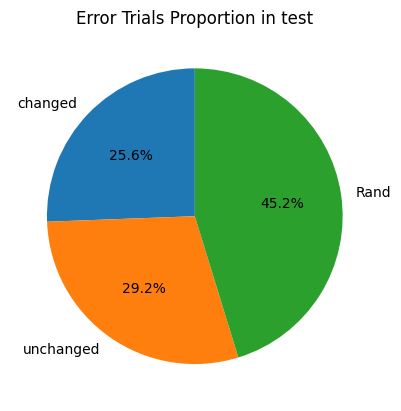

In [48]:
subjs_test_error = subjs_test[subjs_test['isError'] == 1]
plt.pie([len(_) for _ in utils.get_test_changed_unchanged_rand(subjs_test_error)]  , labels = ['changed', 'unchanged', 'Rand'], autopct='%1.1f%%',startangle=90)
plt.title('Error Trials Proportion in test')
plt.show()

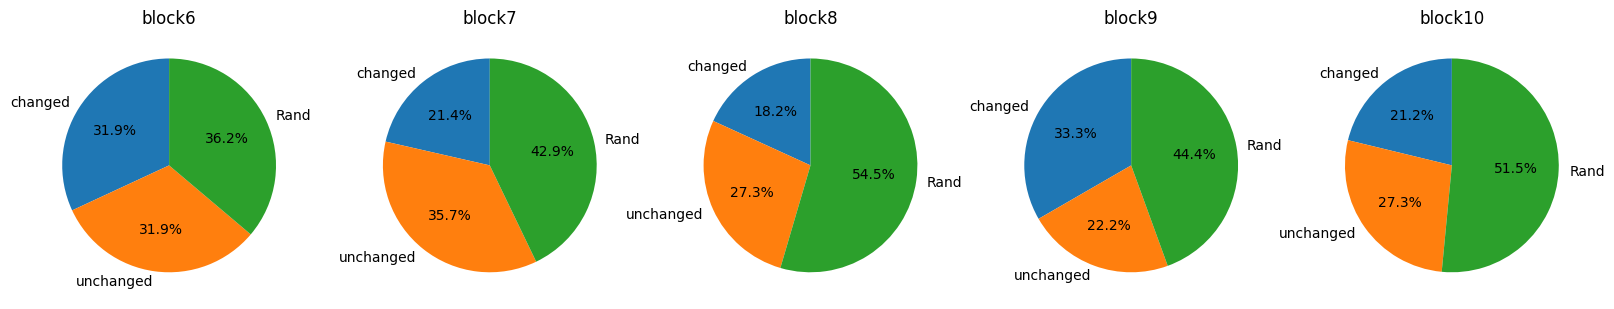

In [49]:
fig, axs = plt.subplots(1,num_test_blocks, figsize= (20,15))
for idx, (blocknum, block) in enumerate(subjs_test_error.groupby('BN')):
    axs[idx].pie([len(_) for _ in utils.get_test_changed_unchanged_rand(block)]   , labels = ['changed', 'unchanged', 'Rand'], autopct='%1.1f%%',startangle=90)
    axs[idx].set_title(f'block{blocknum}')

In [50]:
subjs_presses_test = subjs_presses[subjs_presses['isTrain'] == 0]
subjs_presses_test_error = subjs_presses_test[subjs_presses_test['isPressError'] == 1]

subjs_presses_test_error_changed, subjs_presses_test_error_unchanged , subjs_presses_test_error_rand = utils.get_test_changed_unchanged_rand(subjs_presses_test_error)

/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_test['isChanged'] = subj_test.apply(is_digit_changed, axis = 1)
/Users/amin/projects/ChunkingInterferenceAnalysis/utils.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_test['isRand'] = subj_test.apply(is_rand, axis = 1)


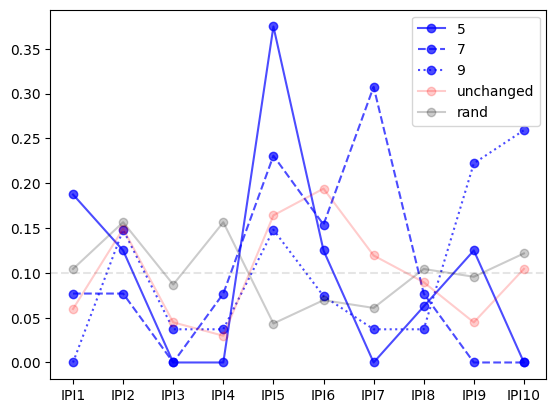

In [168]:
cmap = cm.Pastel1
line_styles = ['-', '--', ':']
opacities = [(0.5/len(digit_change)) * _ for _ in range(1, len(digit_change) + 1)]
for idx, (digit, digit_presses) in enumerate(subjs_presses_test_error_changed.groupby('digitChangePos')):
        proportions = digit_presses['IPI_Number'].value_counts(sort=False)
        proportions = proportions.reindex(['IPI'+ str(_) for _ in range(1, seq_length)], fill_value = 0)
        proportions /= sum(proportions)
        plt.plot(proportions.index.values, proportions, color = 'blue', label = digit, marker = 'o', alpha = 0.7, linestyle = line_styles[idx])

proportions = subjs_presses_test_error_unchanged['IPI_Number'].value_counts(sort=False)
proportions = proportions.reindex(['IPI'+ str(_) for _ in range(1, seq_length)], fill_value = 0)
proportions /= sum(proportions)
plt.plot(proportions.index.values, proportions, color = 'red', label = 'unchanged', marker = 'o', alpha = 0.2)
proportions = subjs_presses_test_error_rand['IPI_Number'].value_counts(sort=False)
proportions = proportions.reindex(['IPI'+ str(_) for _ in range(1, seq_length)], fill_value = 0)
proportions /= sum(proportions)
plt.plot(proportions.index.values, proportions, color = 'black', label = 'rand', marker = 'o', alpha = 0.2)

plt.axhline(y = 0.1, color = 'black', linestyle = '--', alpha = 0.1)

plt.legend()
plt.show()

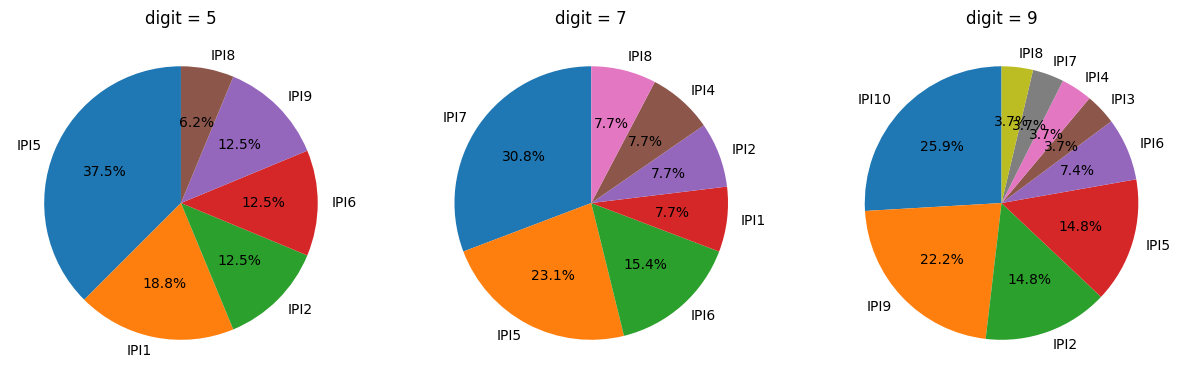

In [58]:
fig, axs = plt.subplots(1, len(digit_change), figsize = (15,20))
for idx, (digit, digit_presses) in enumerate(subjs_presses_test_error_changed.groupby('digitChangePos')):
    axs[idx].pie(digit_presses['IPI_Number'].value_counts(), labels = digit_presses['IPI_Number'].value_counts().index.values,  autopct='%1.1f%%',startangle=90 )
    axs[idx].set_title(f'digit = {digit}')

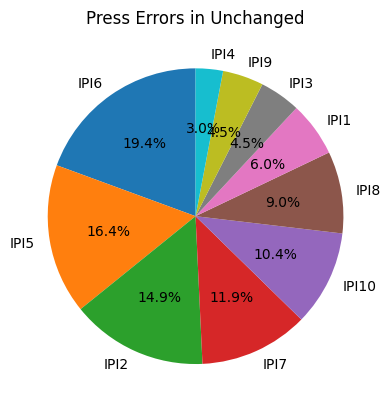

In [ ]:
plt.pie(subjs_presses_test_error_unchanged['IPI_Number'].value_counts(), labels = subjs_presses_test_error_unchanged['IPI_Number'].value_counts().index.values, autopct='%1.1f%%',startangle=90)
plt.title('Press Errors in Unchanged')
plt.show()

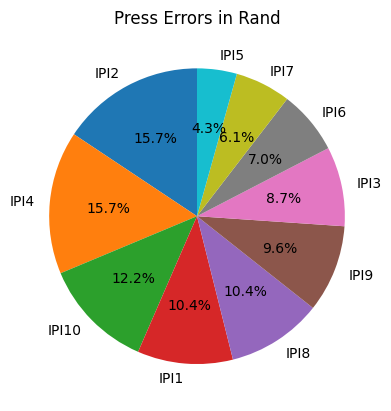

In [169]:
plt.pie(subjs_presses_test_error_rand['IPI_Number'].value_counts(), labels = subjs_presses_test_error_rand['IPI_Number'].value_counts().index.values, autopct='%1.1f%%',startangle=90)
plt.title('Press Errors in Rand')
plt.show()

## Timing Analysis:

In [38]:
press_test_changed, press_test_unchanged, press_test_rand = utils.get_test_changed_unchanged_rand(subjs_presses)

unchanged_agg = press_test_unchanged.groupby(['SubNum', 'IPI_Number']).agg({
    'IPI_Value': 'median'
}).reset_index()


rand_agg = press_test_rand.groupby(['SubNum', 'IPI_Number']).agg({
    'IPI_Value': 'median'
}).reset_index()

changed_agg = press_test_changed.groupby(['SubNum', 'IPI_Number', 'digitChangePos']).agg({
    'IPI_Value': 'median'
}).reset_index()


In [39]:
for presses_agg in [changed_agg, unchanged_agg, rand_agg]:
    presses_agg['is_between'] = presses_agg.apply(flag_between_within_press_test, axis = 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


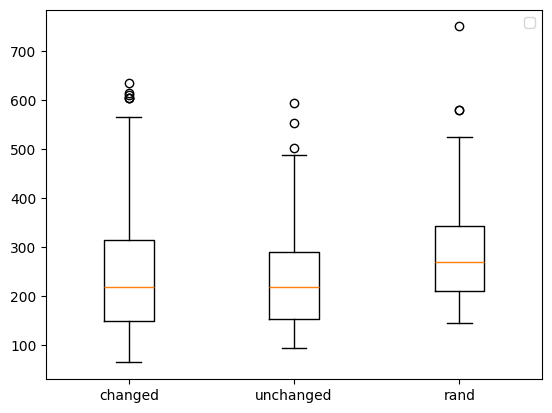

In [68]:
plt.boxplot([changed_agg['IPI_Value'],unchanged_agg['IPI_Value'], rand_agg['IPI_Value']], labels = ['changed', 'unchanged', 'rand']  )
plt.legend()
plt.show()

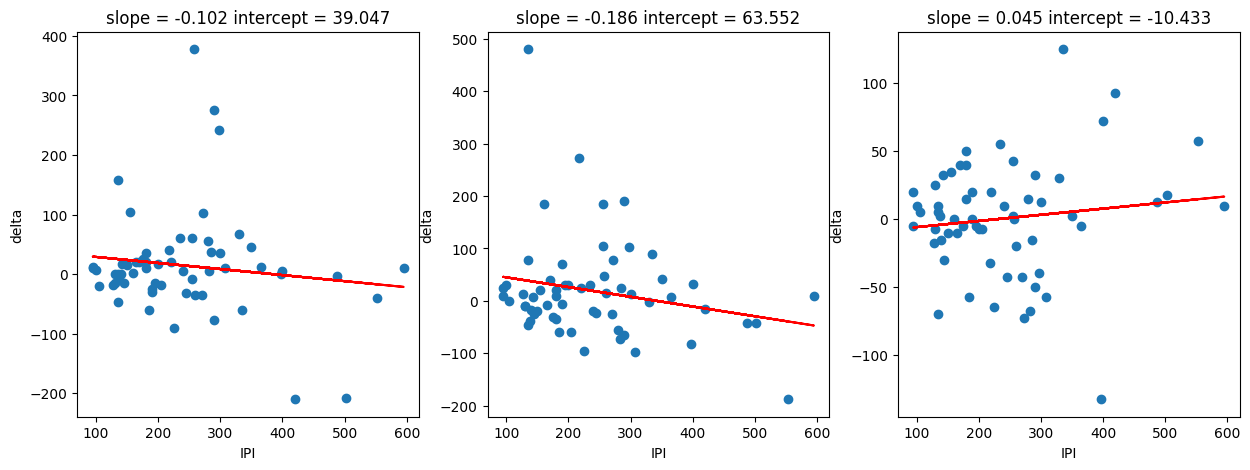

In [63]:
fig , axs = plt.subplots(1,len(digit_change), figsize = (15,5))
for idx , (changed_digit, changed_digit_agg) in enumerate(changed_agg.groupby('digitChangePos')):
    merged_agg = changed_digit_agg.merge(unchanged_agg, on = ['SubNum', 'IPI_Number'], suffixes=('_changed', '_unchanged'))
    slope, intercept = np.polyfit(merged_agg['IPI_Value_unchanged'],  merged_agg['IPI_Value_changed'] - merged_agg['IPI_Value_unchanged'], 1)
    axs[idx].scatter(merged_agg['IPI_Value_unchanged'], merged_agg['IPI_Value_changed'] - merged_agg['IPI_Value_unchanged'])

    model_line = slope * merged_agg['IPI_Value_unchanged'] + intercept
    axs[idx].plot(merged_agg['IPI_Value_unchanged'], model_line, color='red') # our fitted line
    axs[idx].set_title(f"slope = {slope:.3f} intercept = {intercept:.3f}")

    axs[idx].set_xlabel('IPI')
    axs[idx].set_ylabel('delta')

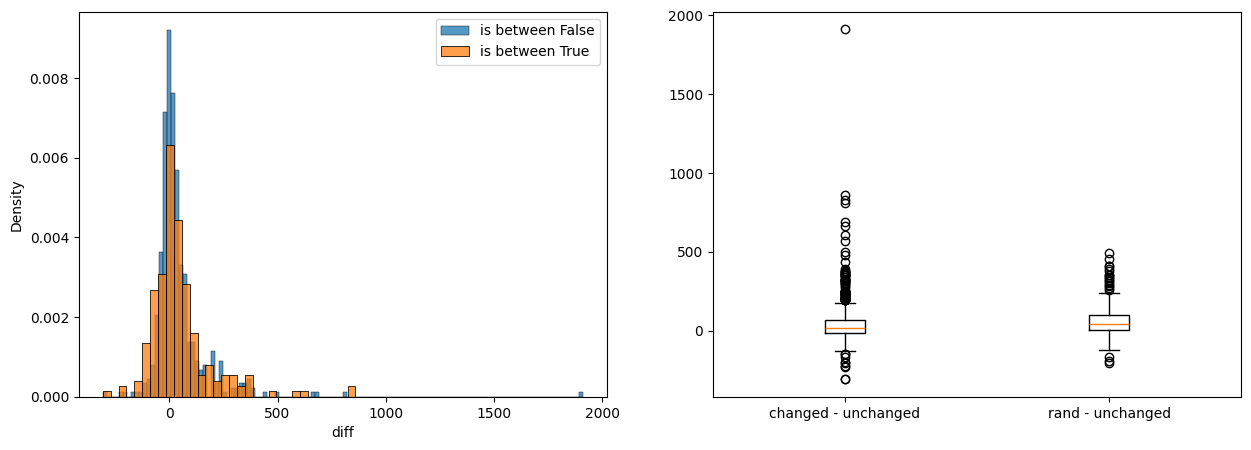

In [266]:
fig , axs = plt.subplots(1,2, figsize = (15,5))
for flag, press_diff_group in press_diff.groupby('is_between'):
    sns.histplot(press_diff_group['diff'], label = 'is between ' + str(flag), ax=axs[0], stat = 'density')

axs[1].boxplot([press_diff['diff'], press_diff_rand['diff']], labels = ['changed - unchanged', 'rand - unchanged'] )

axs[0].legend()
plt.show()

<Axes: xlabel='diff', ylabel='Count'>

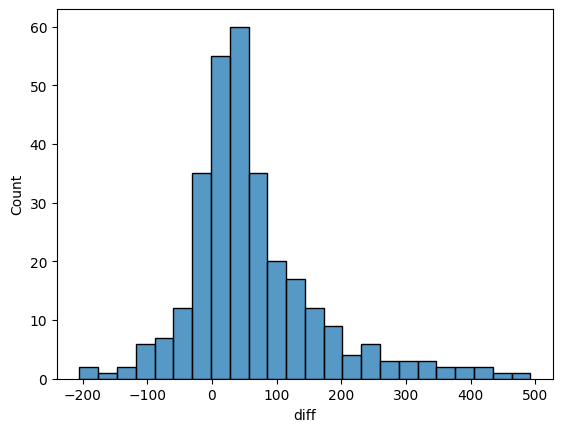

In [211]:
sns.histplot(press_diff_rand['diff'])

In [ ]:
# utils.diff_trend_test(subjs_test, changed_finger=5)
# utils.diff_trend_test(subjs_test, changed_finger=7)
# utils.diff_trend_test(subjs_test, changed_finger=9)

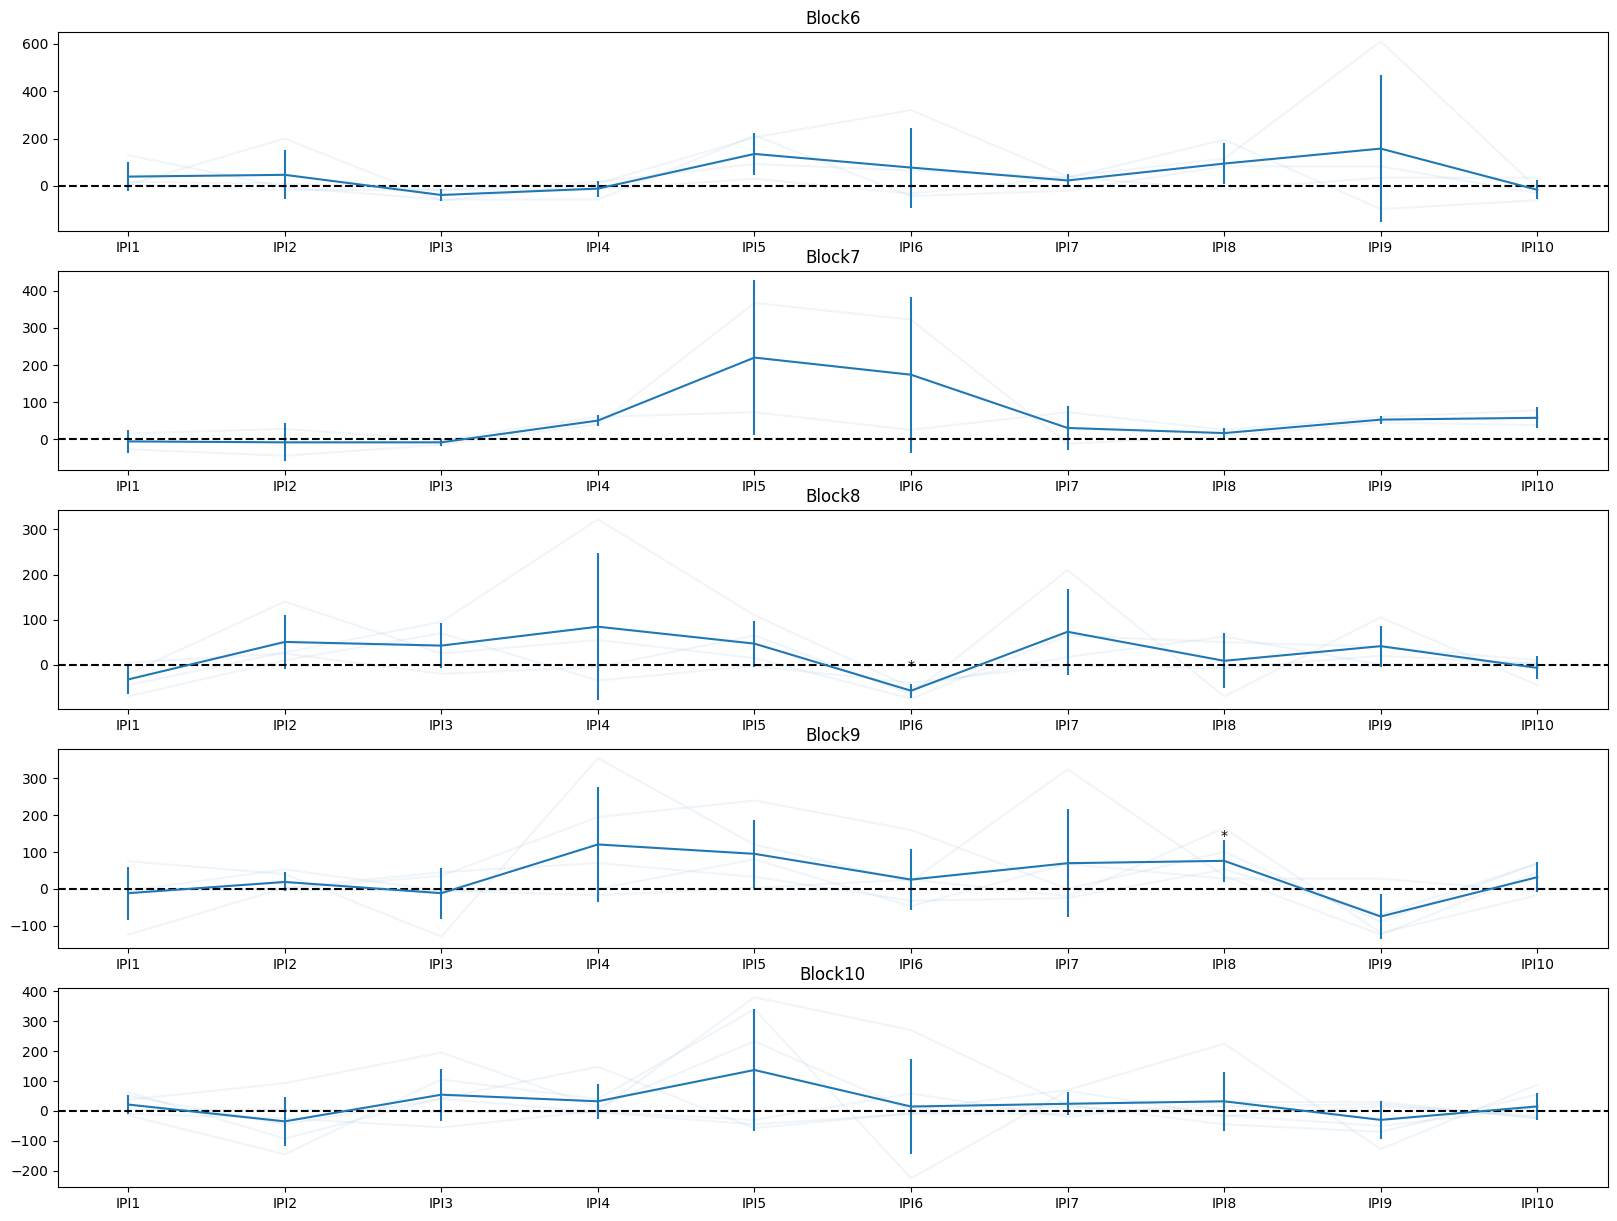

In [ ]:
utils.finger_press_diff_trend_block(press_diff, changed_finger=5)

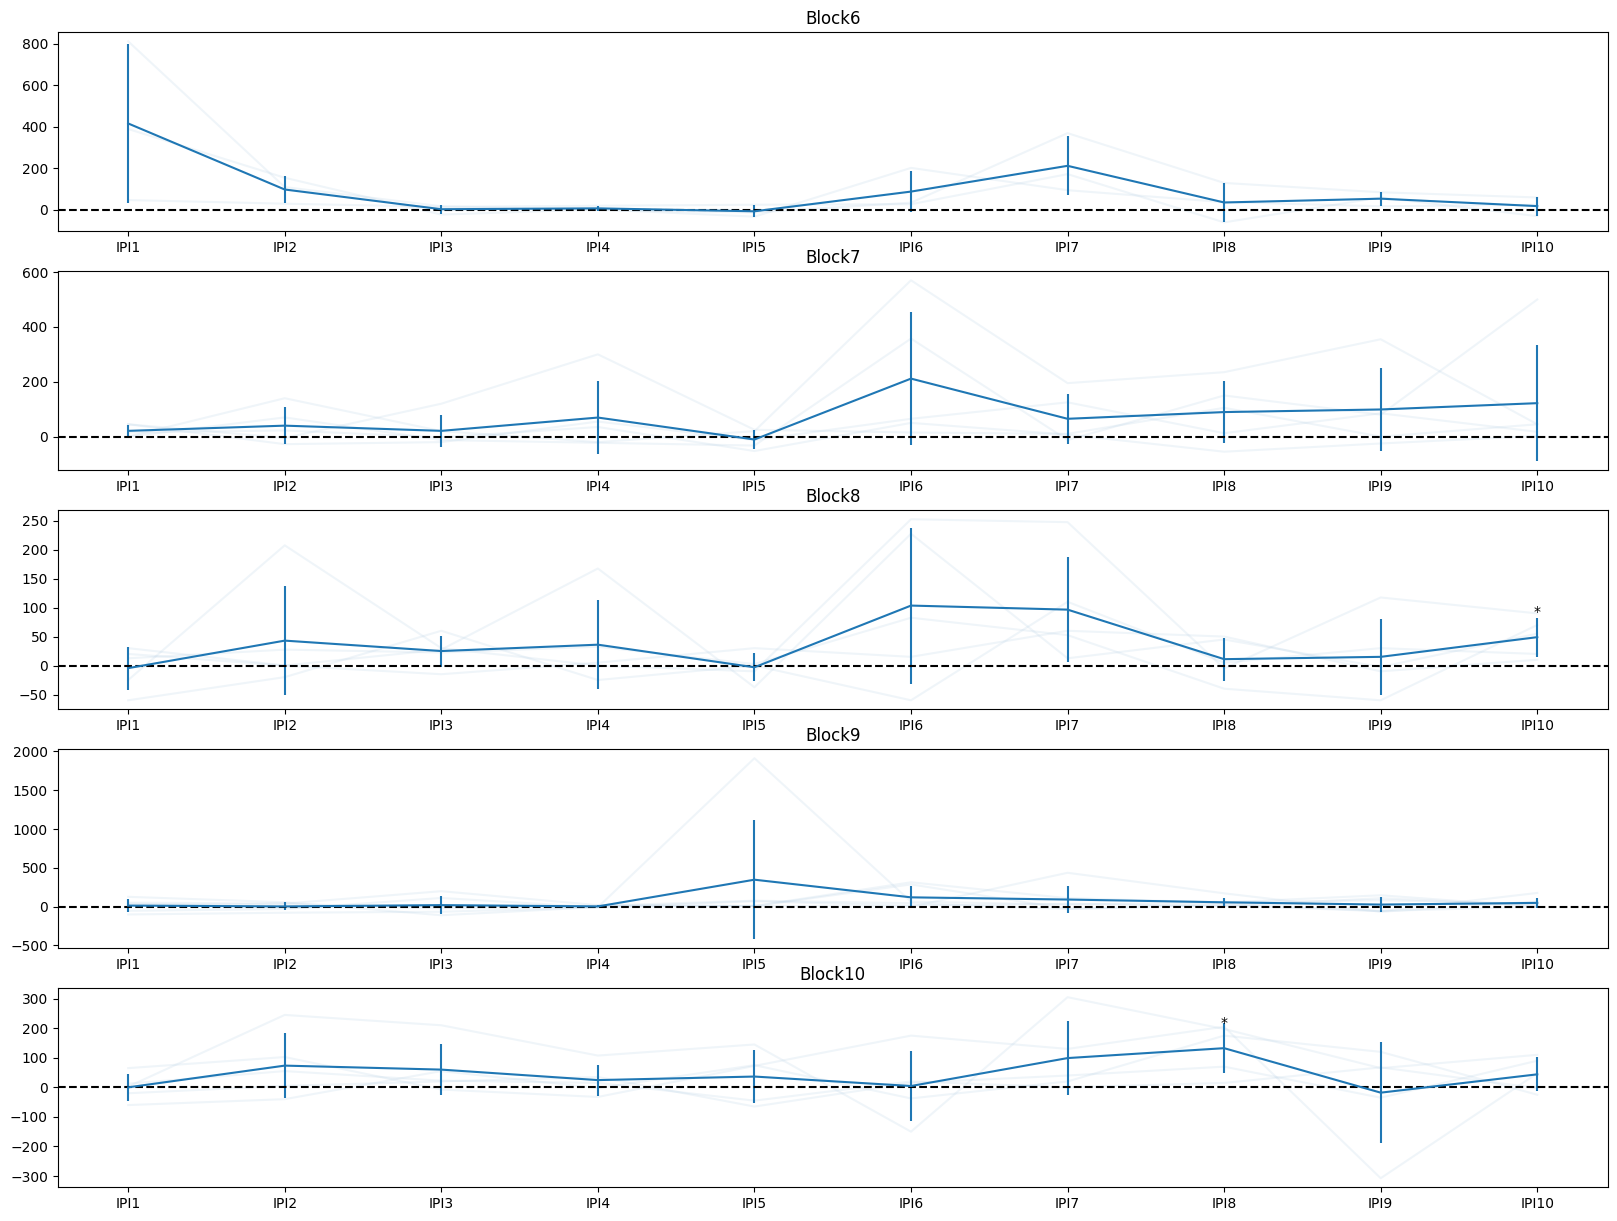

In [ ]:
utils.finger_press_diff_trend_block(press_diff, changed_finger=7)

/Users/amin/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


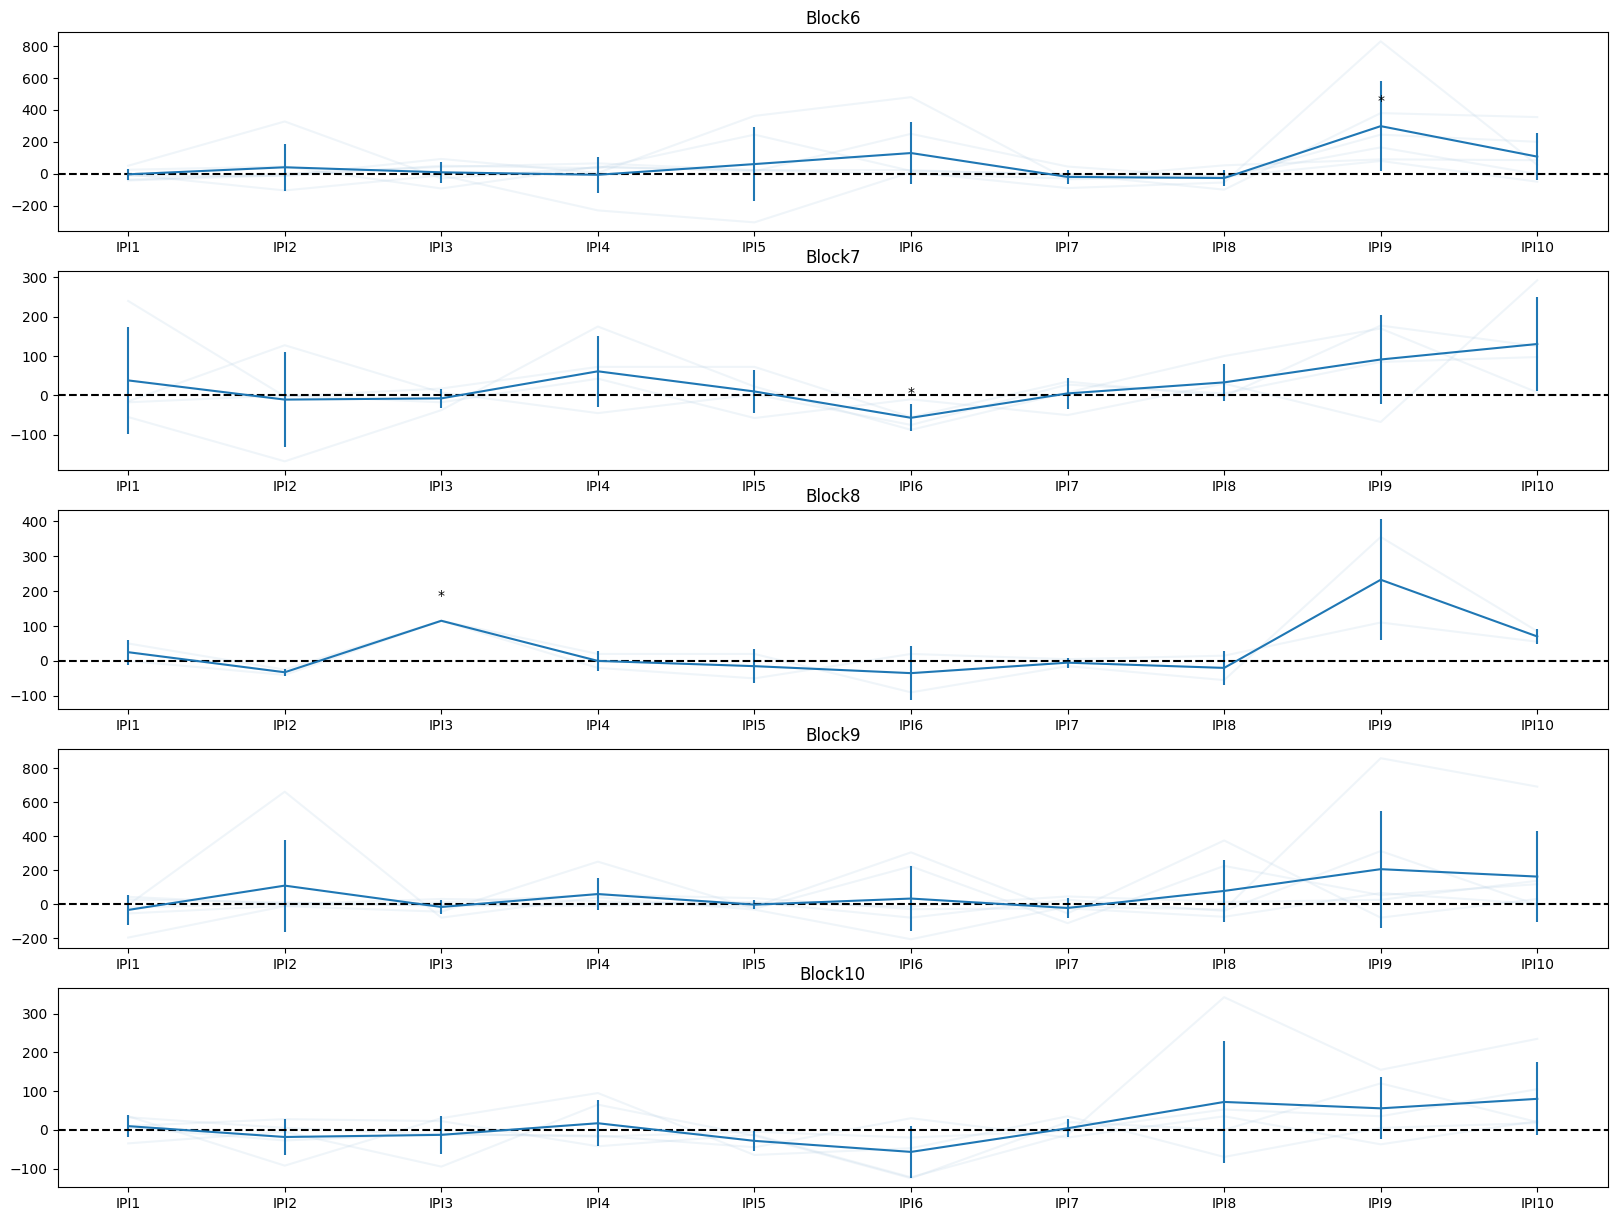

In [ ]:
utils.finger_press_diff_trend_block(press_diff, changed_finger=9)

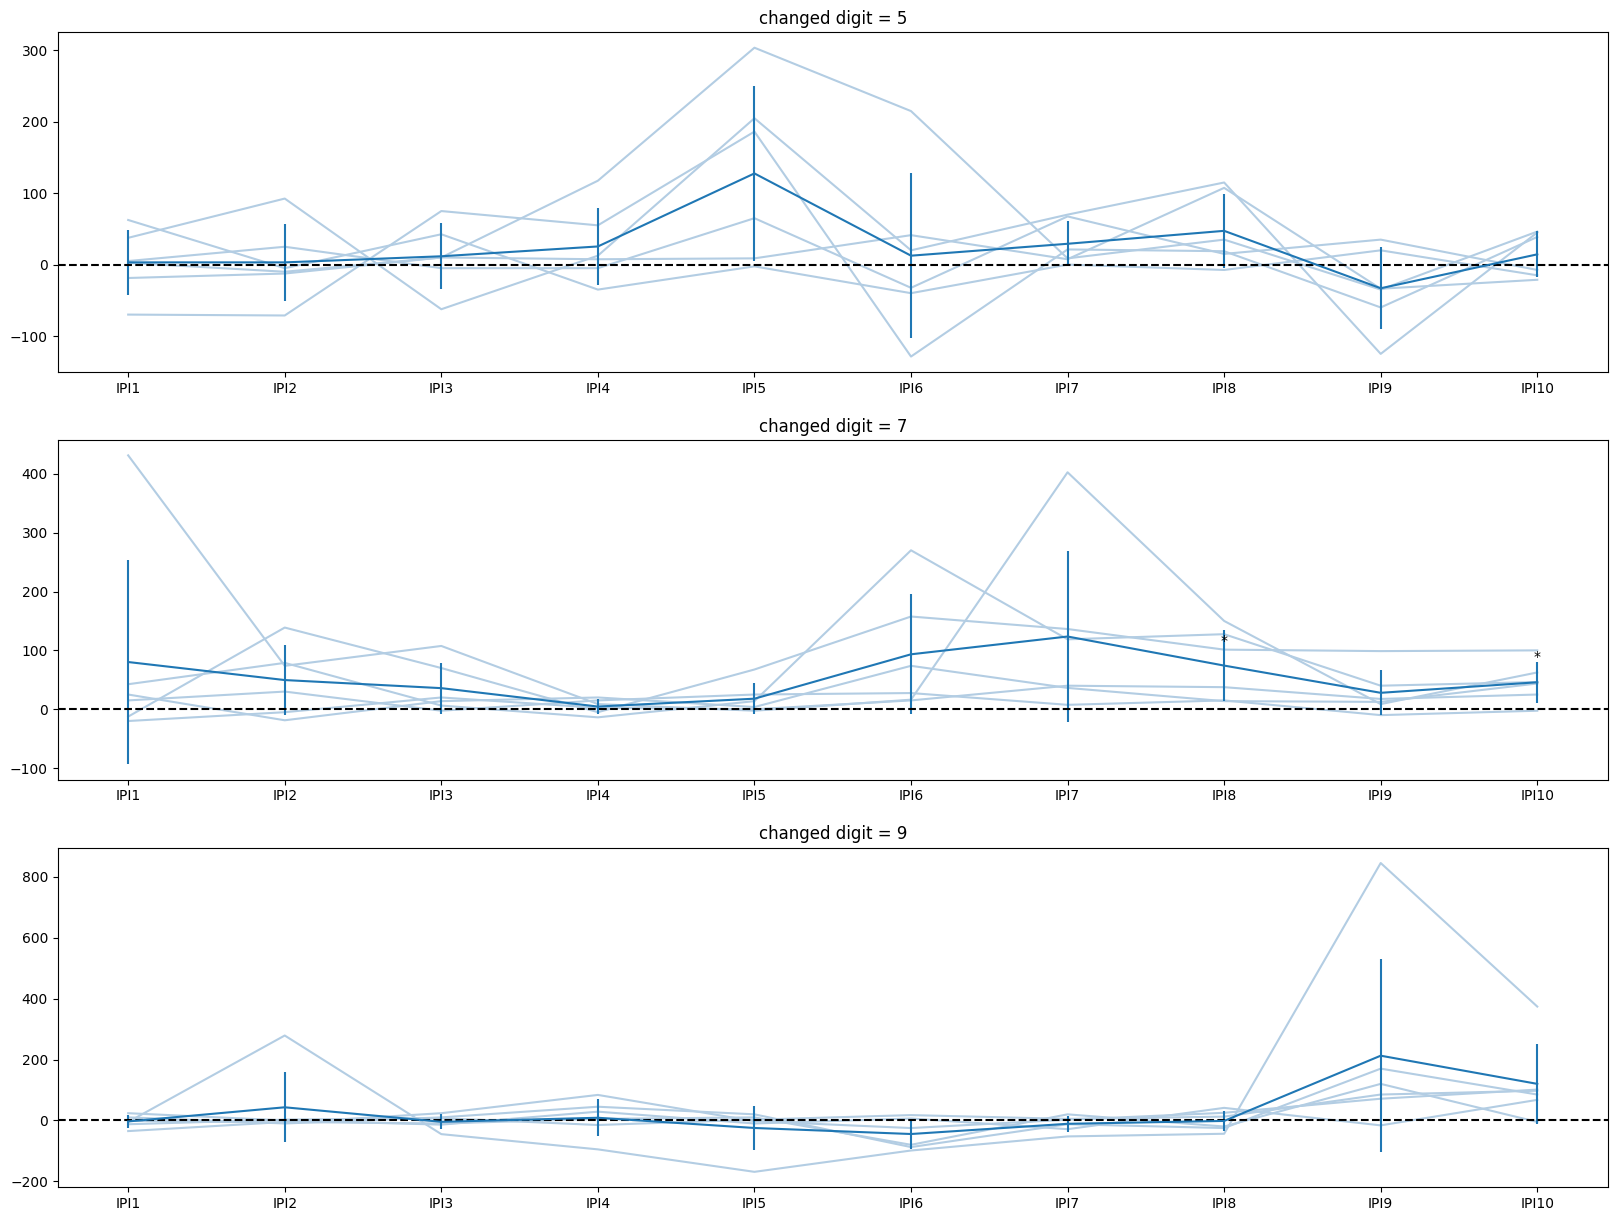

In [ ]:
utils.finger_press_diff_trend(press_diff)

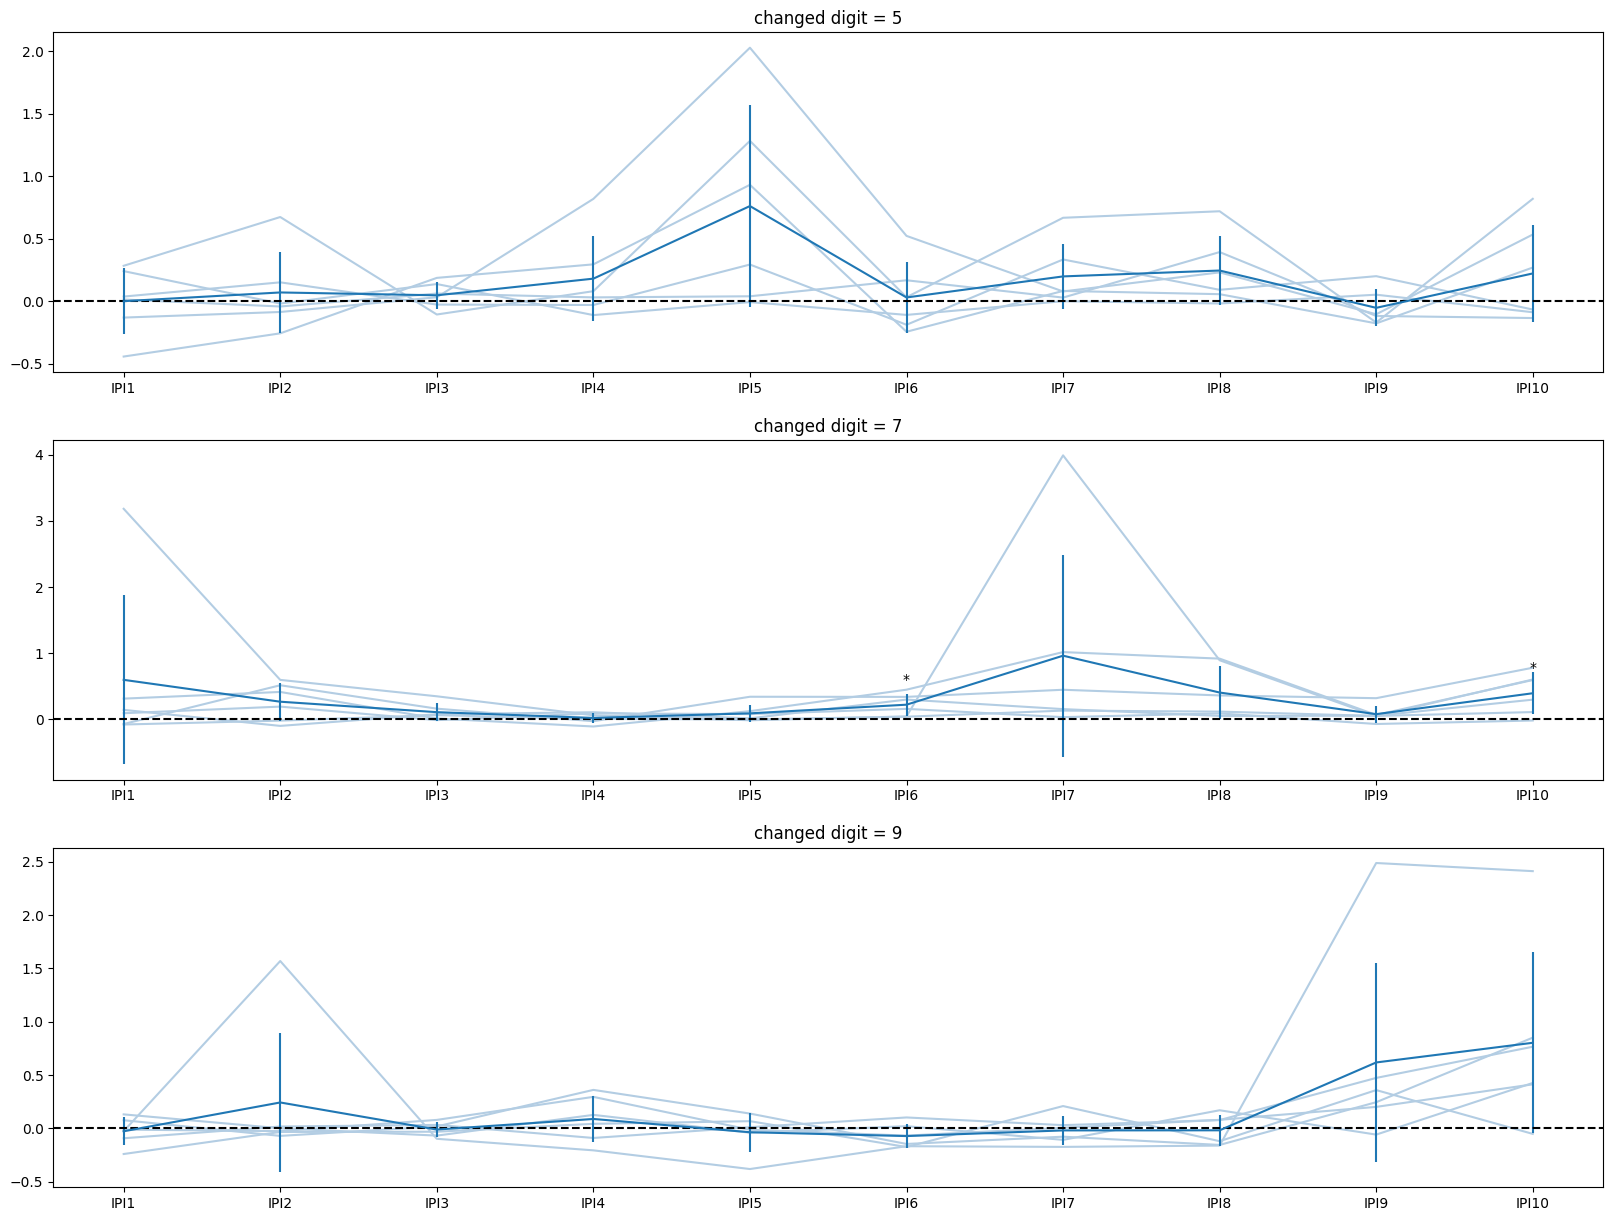

In [28]:
utils.finger_press_diff_rel_trend(press_diff)

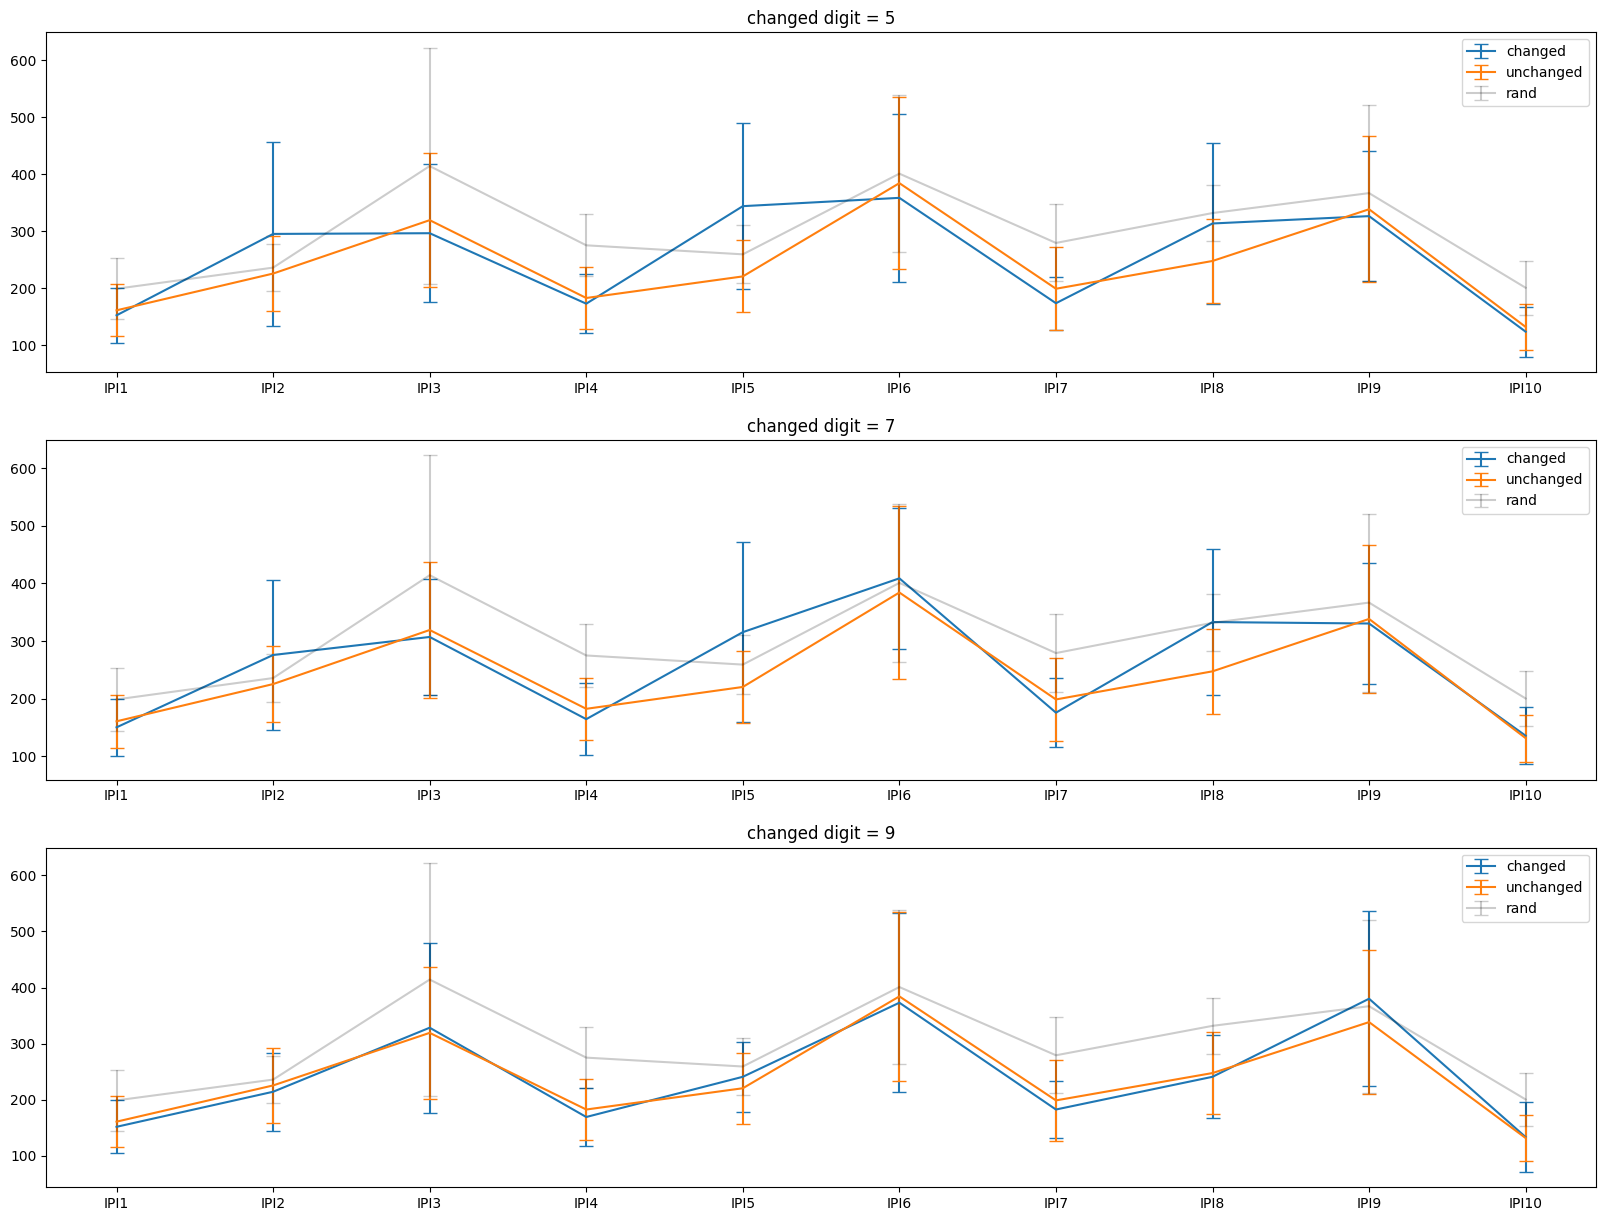

In [44]:
fig, axs = plt.subplots(len(digit_change), figsize= (20,15))
cmap = cm.Pastel1
capsize = 5

for idx, change in enumerate(digit_change):
    changed_agg_finger = changed_agg[changed_agg['digitChangePos'] == change]

    # for subnum, subj in changed_agg_finger.groupby(['SubNum']):
    #     subj = subj.iloc[index_natsorted(subj['IPI_Number'])].reset_index(drop=True)
    #     axs[idx].plot(subj['IPI_Number'], subj['IPI_Value'], color = cmap(1))


    finger_agg = changed_agg_finger.groupby(['IPI_Number']).agg({
        'IPI_Value': ['mean', 'std']
    }).reset_index()


    finger_agg = finger_agg.iloc[index_natsorted(finger_agg['IPI_Number'])].reset_index(drop=True)
    axs[idx].errorbar(finger_agg['IPI_Number'], finger_agg['IPI_Value']['mean'], yerr = finger_agg['IPI_Value']['std'], label = 'changed', capsize = capsize)

    finger_agg_unchnaged = unchanged_agg.groupby(['IPI_Number']).agg({
        'IPI_Value': ['mean', 'std']
    }).reset_index()

    finger_agg_unchnaged = finger_agg_unchnaged.iloc[index_natsorted(finger_agg_unchnaged['IPI_Number'])].reset_index(drop=True)
    axs[idx].errorbar(finger_agg_unchnaged['IPI_Number'], finger_agg_unchnaged['IPI_Value']['mean'], yerr = finger_agg_unchnaged['IPI_Value']['std'], label = 'unchanged', capsize = capsize)

    finger_agg_rand = rand_agg.groupby(['IPI_Number']).agg({
        'IPI_Value': ['mean', 'std']
    }).reset_index()

    finger_agg_rand = finger_agg_rand.iloc[index_natsorted(finger_agg_rand['IPI_Number'])].reset_index(drop=True)
    axs[idx].errorbar(finger_agg_rand['IPI_Number'], finger_agg_rand['IPI_Value']['mean'], yerr = finger_agg_rand['IPI_Value']['std'], color = 'black', label = 'rand', capsize = capsize, alpha = 0.2)
    
    axs[idx].legend()

    axs[idx].set_title(f'changed digit = {change}')